## Clustering and functional analysis on Bayesian timescales
Author: Robert Ietswaart  
Date: 20230110  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4

Source: `Function_20220301.ipynb`  
For Subcellular Timelapse seq project. 

In [2]:
import os
import re
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.stats import gmean, gstd, spearmanr, mode
import new_total_ratio_jit as ntr
import fit

import urllib.request
from goatools.obo_parser import GODag
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu

# from sklearn.cluster import AgglomerativeClustering

# from __init__ import __version__
from __init__ import default_logger_format, default_date_format

In [3]:
# def main():
np.random.seed(12345)

parser = argparse.ArgumentParser(
    description='Functional analysis of Bayes timescales.')

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [4]:
path = os.path.join('/n','groups','churchman','ri23','bseq','Function20230110')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('Function')
log_file = os.path.join(path,'LogErr', 'Functional_Analysis_20230110.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

organisms = ['m','h']
org_map = {'m': 'mouse', 'h': 'human'}
org_id_map = {'m': 10090, 'h': 9606}
fracs = ['chr', 'nuc', 'cyto', 'poly', 'tot']
reps = ['G','H','R','S','T','U']
red_reps = ['G_R', 'H_S', 'T', 'U']
# org_reps = {'m': ['G','H','R','S'], 'h': ['T', 'U']}
org_red_reps = {'m': ['G_R','H_S'], 'h': ['T', 'U']}
red_r = {'G': 'G_R', 'H': 'H_S', 'R': 'G_R', 'S': 'H_S', 'T': 'T', 'U': 'U'}
time_id = [str(i) for i in range(1,6)]
background_id = {r: '1' for r in reps}
time_mins = [0, 15, 30, 60, 120]
# T_bound_lo = 1e-4 #unit: min, ~6 ms
# T_bound_hi = 1e4 #unit: min, ~7 days

fracs_model = {'chr': ['chr_fit'],  
               'nuc': ['nuc_fit', 'nuc_fit_from_chr', 'nuc_fit_from_nucdeg'],
               'cyto': ['cyto_fit_from_nucres', 'cyto_fit_from_chr', 'cyto_fit_from_nucdeg'],
               'poly': ['poly_fit_from_nucres'],
               'tot': ['tot_fit', 'tot_pred_from_nucres', 'tot_pred_from_chr', 
                       'tot_fit_from_nucdeg', 'tot_pred_from_nucdeg']}

RATE_TYPE = ['half_life_','k_']
rt = RATE_TYPE[0]

Timescales = ['chr',
              'chr_release',
              'nucdeg',
              'nucexp',
              'nuc',
              'cyto',
              'poly_entry',
              'whole_cell']
Timescales = [rt + ts for ts in Timescales]


# improved color code from 20211104
cmap={'chr':'#1D5386', 'nuc':'#506C23', 'cyto':'#B80000', 'poly':'#9E2E93', 'tot':'#D66B1F'}

TC_TYPES = ['top1000','bottom500']#BM model turnover method to estimate TC
OUT_TYPES = ['.Mean', '.MAP', '.0.975.quantile', '.0.025.quantile']


GS = dict()         #GRAND-SLAM
B = dict()          #Bayes fits file
K = dict()          #Bayes Factor
for o in organisms:  
    GS[o] = dict()   
    if o == 'm':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210506')   
    elif o == 'h':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210713_human')
    path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20230128')
    filename_b = 'Bayes_Rates_20230128_'+ org_map[o] + '.tsv'
    path_k = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20221206')
    filename_k = 'Bayes_factor_20230317_' + org_map[o] + '_final.tsv'

    B[o] = pd.read_csv(os.path.join(path_b, filename_b), sep='\t')
    K[o] = pd.read_csv(os.path.join(path_k, filename_k), sep='\t')
    
    for r in reps:
        for fr in fracs:
            for tc in TC_TYPES:
                filename_gs = r + '_' + fr + '_noMT_' + tc + '.csv'
                if os.path.exists(os.path.join(path_gs, filename_gs)):
                    GS[o][red_r[r]+fr+tc]= pd.read_csv(os.path.join(path_gs, filename_gs) ,index_col=0)

### Clustering parameters: 
optimized for visualization and robustness of conclusions  
rt = half_life_, metric = seuclidean, N_clust = 50 (low/up bound controls 35 and 100), 
w Poly no MAP lower / upper cap 1e-1, 24h

In [5]:
Timescales_order = ['whole_cell',
                    'chr',
                    'nuc',
                    'cyto',
                    'poly_entry',
                    'chr_release',
                    'nucdeg',
                    'nucexp']

Timescales_v2_order =  Timescales_order
Timescales_v2_order = [ts.replace('_', ' ') for ts in Timescales_v2_order]
Timescales_order = [rt + ts for ts in Timescales_order]
Timescales_clust = ['chr',
                    'nuc',
                    'cyto',
                    'poly_entry',
                    'whole_cell']
Timescales_clust = [rt + ts for ts in Timescales_clust]

In [6]:
clust_cols = dict()
vis_cols = dict()
deriv_cols = dict()
idx_add = 5
for o in organisms:
    vis_cols[o] = []
    clust_cols[o] = []
    deriv_cols[o] = []
    for ts in Timescales_clust:
        for ot in [OUT_TYPES[3], OUT_TYPES[1], OUT_TYPES[2]]:
            for rr in org_red_reps[o]:
                if not ts+ot == rt+'poly_entry'+OUT_TYPES[1]:#Poly are less reproducible: use only CI for clust
                    clust_cols[o].append(rr+'.'+ts+ot)

    vis_cols[o] = []
    for ts in Timescales:#different col order to match Brendan's Fig1
        for ot in [OUT_TYPES[3], OUT_TYPES[1], OUT_TYPES[2]]:
            for rr in org_red_reps[o]:
                vis_cols[o].append(rr+'.'+ts+ot)
                
    deriv_cols[o] = []
    for ts in Timescales_order[idx_add:]:
        for ot in [OUT_TYPES[3], OUT_TYPES[1], OUT_TYPES[2]]:
            for rr in org_red_reps[o]:
                deriv_cols[o].append(rr+'.'+ts+ot)

clust_cols['h']

['T.half_life_chr.0.025.quantile',
 'U.half_life_chr.0.025.quantile',
 'T.half_life_chr.MAP',
 'U.half_life_chr.MAP',
 'T.half_life_chr.0.975.quantile',
 'U.half_life_chr.0.975.quantile',
 'T.half_life_nuc.0.025.quantile',
 'U.half_life_nuc.0.025.quantile',
 'T.half_life_nuc.MAP',
 'U.half_life_nuc.MAP',
 'T.half_life_nuc.0.975.quantile',
 'U.half_life_nuc.0.975.quantile',
 'T.half_life_cyto.0.025.quantile',
 'U.half_life_cyto.0.025.quantile',
 'T.half_life_cyto.MAP',
 'U.half_life_cyto.MAP',
 'T.half_life_cyto.0.975.quantile',
 'U.half_life_cyto.0.975.quantile',
 'T.half_life_poly_entry.0.025.quantile',
 'U.half_life_poly_entry.0.025.quantile',
 'T.half_life_poly_entry.0.975.quantile',
 'U.half_life_poly_entry.0.975.quantile',
 'T.half_life_whole_cell.0.025.quantile',
 'U.half_life_whole_cell.0.025.quantile',
 'T.half_life_whole_cell.MAP',
 'U.half_life_whole_cell.MAP',
 'T.half_life_whole_cell.0.975.quantile',
 'U.half_life_whole_cell.0.975.quantile']

In [7]:
# vis_cols['h']
deriv_cols['h']

['T.half_life_chr_release.0.025.quantile',
 'U.half_life_chr_release.0.025.quantile',
 'T.half_life_chr_release.MAP',
 'U.half_life_chr_release.MAP',
 'T.half_life_chr_release.0.975.quantile',
 'U.half_life_chr_release.0.975.quantile',
 'T.half_life_nucdeg.0.025.quantile',
 'U.half_life_nucdeg.0.025.quantile',
 'T.half_life_nucdeg.MAP',
 'U.half_life_nucdeg.MAP',
 'T.half_life_nucdeg.0.975.quantile',
 'U.half_life_nucdeg.0.975.quantile',
 'T.half_life_nucexp.0.025.quantile',
 'U.half_life_nucexp.0.025.quantile',
 'T.half_life_nucexp.MAP',
 'U.half_life_nucexp.MAP',
 'T.half_life_nucexp.0.975.quantile',
 'U.half_life_nucexp.0.975.quantile']

In [8]:
## Prefilter timescales for NA data
T_bf = 100

C = copy.deepcopy(B)
for o in organisms:
    C[o] = C[o].merge(K[o], on='Gene', suffixes=('', '_bf'))
    logger.info('%s all genes: %d' % (org_map[o], len(C[o])))
    C[o] = C[o][~C[o][clust_cols[o]].isna().any(axis=1)]
    logger.info('%s genes without NA cluster timescales: %d' % (org_map[o], len(C[o])))
    
    for ts in Timescales_order:
        for ot in OUT_TYPES:
            for rr in org_red_reps[o]: 
                if ts == rt + 'chr_release':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg'+ot].where(
                        C[o]['PUND'], C[o][rr+'.'+rt+'chr'+ot]))
                if ts == rt + 'nucdeg':#only for nucdeg genes according to Bayes Factor
                    C[o][rr+'.'+ts+ot].where(C[o]['PUND'], (24*60), inplace=True)
                if ts == rt + 'nucexp':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg'+ot].where(
                        C[o]['PUND'], C[o][rr+'.'+ts+'_from_nucres'+ot]))

                ###Clip range of values beyond realistic timescale values: 0.1min and 24h 
                #do not clip 1 fraction: not good for robustness of clustering: avoid or clip all fractions
                if rr+'.'+ts+ot in C[o].keys():
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] > 1e-1, 1e-1, inplace=True) 
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] < (24*60), (24*60), inplace=True)                  


INFO: [2023-04-01 14:44:33] Function - mouse all genes: 17584
INFO: [2023-04-01 14:44:33] Function - mouse genes without NA cluster timescales: 11034
INFO: [2023-04-01 14:44:33] Function - human all genes: 18155
INFO: [2023-04-01 14:44:33] Function - human genes without NA cluster timescales: 11003


## Hierarchical clustering in Python:
and NOT USED heatmap visualization. See below for R visualization.  
https://stackoverflow.com/questions/27924813/extracting-clusters-from-seaborn-clustermap

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

In [9]:
g = dict()
row_link = dict()

N_clust =  70 #for revisions: also tried 65, original 50, 35 (lower bound control), 100 (upper bound control)
clust = dict()
for o in organisms[1:]:
    logger.info('start hierarchical clustering %s' % o)
    row_link[o] = hierarchy.linkage(np.log(C[o][clust_cols[o]]), 
                                    metric ='seuclidean', #metric ='correlation' = not good
                                    method='complete',#default:'complete',
                                    optimal_ordering=False)#True: takes a long time and does not help
    clust[o] = hierarchy.fcluster(row_link[o], t=N_clust, criterion='maxclust')
    C[o].insert(loc=1, column='Cluster', value=clust[o])
    
    
    #prep for colored clusters 
    clust_cmap = dict()
    temp_cmap = plt.get_cmap('gist_ncar', N_clust) 
    #'Paired' 'tab20b' is name of colormap, you need to choose a continuous one 
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    for i in range(1,(N_clust+1)):
        clust_cmap[i] = temp_cmap(i-1) 
    row_colors = C[o]['Cluster'].map(clust_cmap) 
    


    logger.info('end hierarchical clustering %s' % o)

INFO: [2023-04-01 14:44:34] Function - start hierarchical clustering h
INFO: [2023-04-01 14:44:41] Function - end hierarchical clustering h


# Visualization of clusters

In [10]:
o='h' #'m' #
centroid = dict()
centroid['compartment'] = Timescales_order
N_ok_clust = 0
ok_clust = []
for i in range(1,(N_clust+1)):
    df = C[o][C[o]['Cluster']==i]
    for rr in org_red_reps[o]:
        centroid[str(i)+rr+'median'] = []
        centroid[str(i)+rr+'ci_lo'] = []
        centroid[str(i)+rr+'ci_hi'] = []
        for ts in Timescales_order:#[:idx_add]:
            ci_lo = df[rr+'.'+ts+OUT_TYPES[3]].median()
            ci_hi = df[rr+'.'+ts+OUT_TYPES[2]].median()
            centroid[str(i)+rr+'ci_lo'].append(ci_lo)
            centroid[str(i)+rr+'ci_hi'].append(ci_hi)
            centroid[str(i)+rr+'median'].append(df[rr+'.'+ts+OUT_TYPES[1]].median())

#Determine OK clusters: reproducible and size > 1
r1 = org_red_reps[o][0]
r2 = org_red_reps[o][1]
for i in range(1,(N_clust+1)):
    bool_ok_clust = True
    if len(C[o][C[o]['Cluster']==i]) < 5:#==1:
        bool_ok_clust = False
    for j, ts in enumerate(Timescales_order[:idx_add]):
        #if not reproducible: more than 3x difference between reps for compartments used for clustering
        if abs(np.log(centroid[str(i)+r1+'median'][j]) -  np.log(centroid[str(i)+r2+'median'][j])) > np.log(10):
            bool_ok_clust = False
            break
    if bool_ok_clust:
        N_ok_clust += 1
        ok_clust.append(i)
        
centroid = pd.DataFrame(centroid)
logger.info('Reproducible clusters with size > 1: %d / %d ' % (N_ok_clust, N_clust))

INFO: [2023-04-01 14:44:43] Function - Reproducible clusters with size > 1: 32 / 70 


cluster: 2 N_genes=53
cluster: 3 N_genes=64
cluster: 4 N_genes=276
cluster: 5 N_genes=152
cluster: 6 N_genes=146
cluster: 9 N_genes=32
cluster: 10 N_genes=24
cluster: 11 N_genes=5
cluster: 12 N_genes=5
cluster: 13 N_genes=214
cluster: 14 N_genes=44
cluster: 17 N_genes=93
cluster: 18 N_genes=463
cluster: 19 N_genes=425
cluster: 21 N_genes=466
cluster: 24 N_genes=41
cluster: 25 N_genes=105
cluster: 27 N_genes=37
cluster: 29 N_genes=1778
cluster: 30 N_genes=313
cluster: 32 N_genes=376
cluster: 33 N_genes=121


/n/groups/churchman/ri23/code/RNAdecayenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


cluster: 34 N_genes=482
cluster: 35 N_genes=38
cluster: 36 N_genes=737
cluster: 40 N_genes=2205
cluster: 41 N_genes=440
cluster: 43 N_genes=159
cluster: 45 N_genes=36
cluster: 46 N_genes=150
cluster: 48 N_genes=832
cluster: 70 N_genes=71


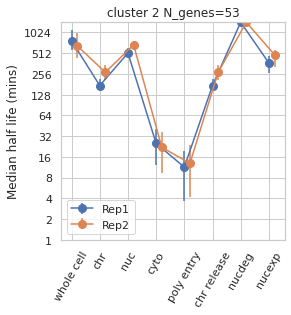

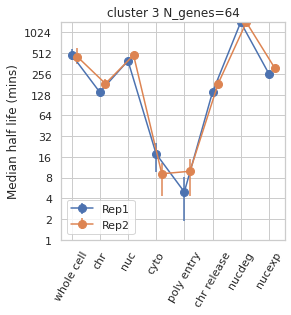

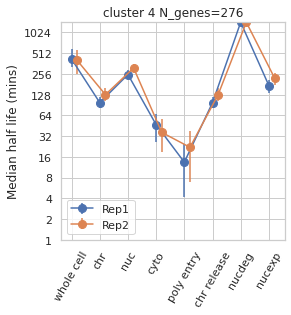

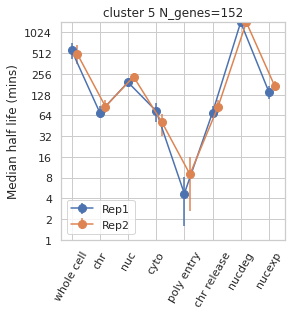

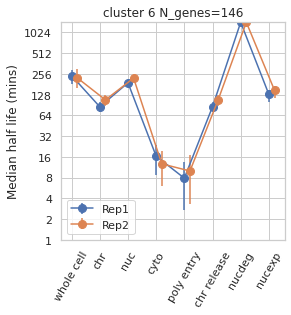

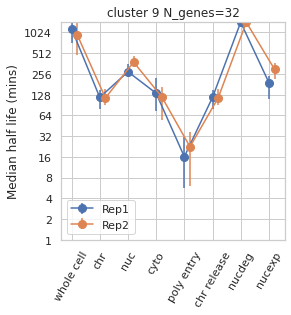

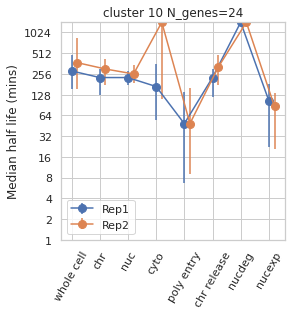

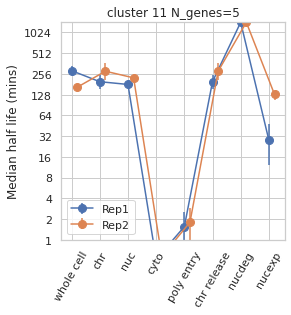

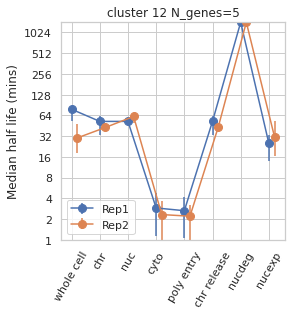

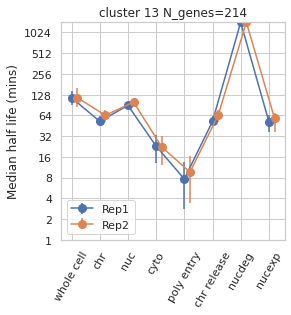

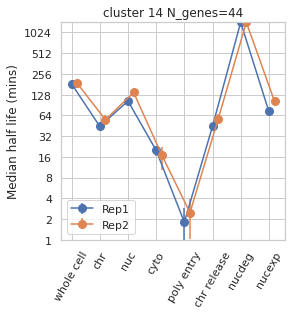

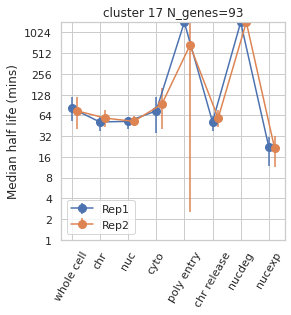

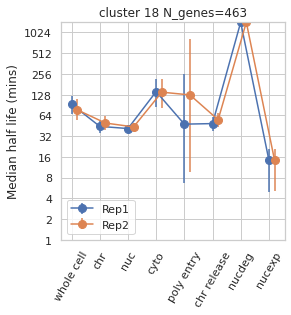

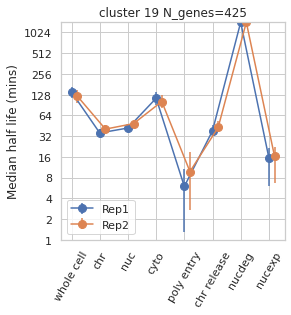

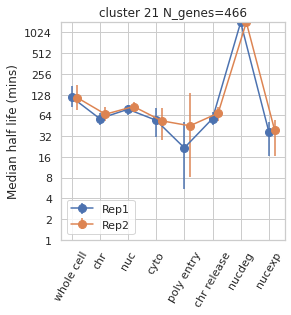

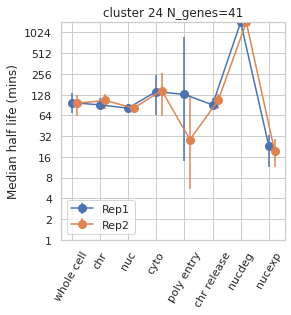

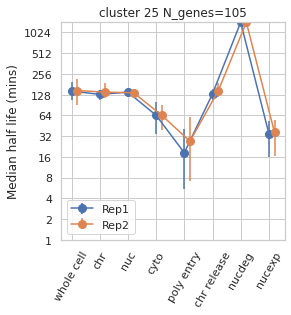

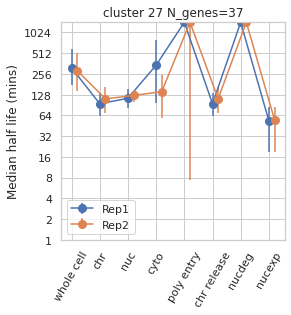

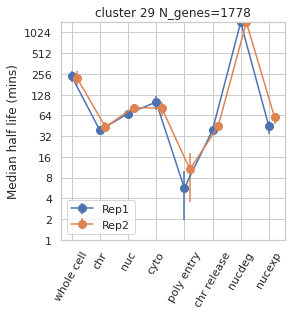

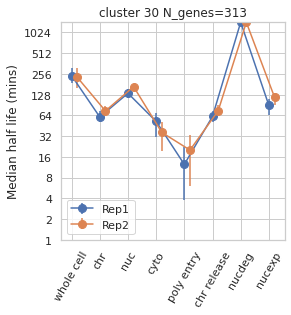

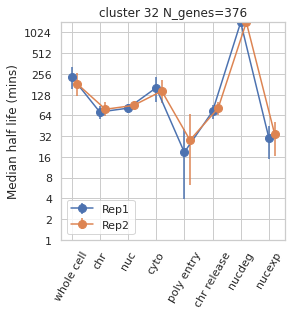

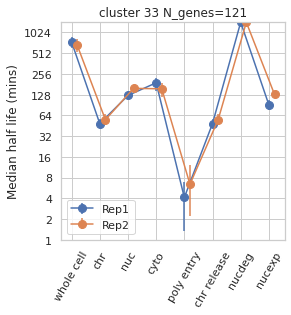

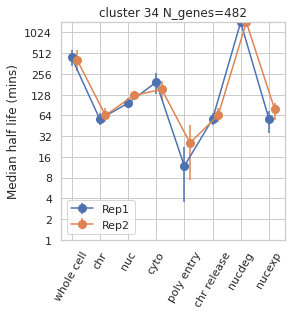

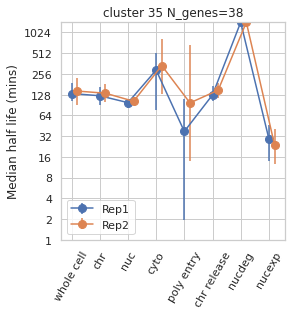

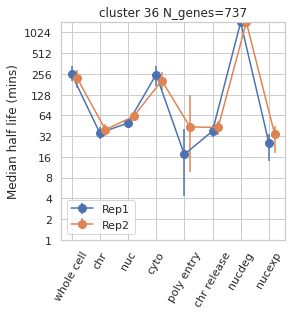

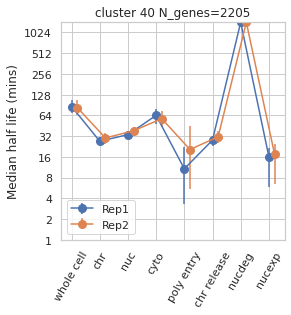

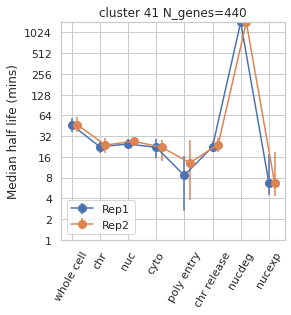

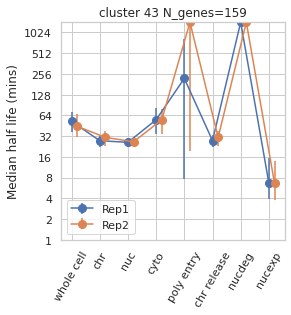

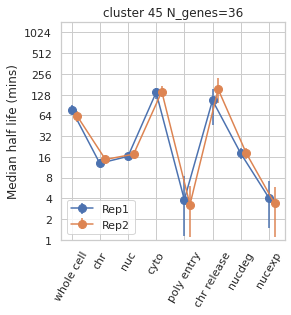

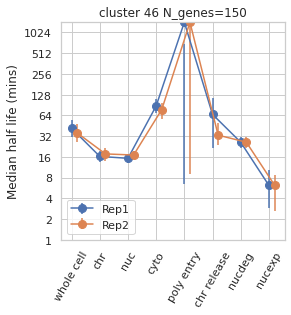

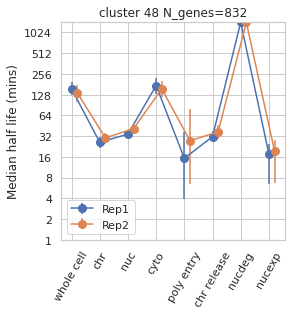

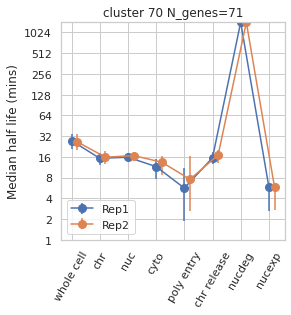

In [10]:
x_clust = np.arange(len(Timescales_order))#[:idx_add]))  #the label locations

for i in range(1,(N_clust+1)):
    if i in ok_clust:
        print('cluster: '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        sns.set(style="whitegrid", color_codes=True,font_scale=1)
        f, ax = plt.subplots(figsize=(4, 4))   
        leg = []
        for j, rr in enumerate(org_red_reps[o]):
            ax.errorbar(x=x_clust+(0.2*j), y=centroid[str(i)+rr+'median'],
                        yerr=[centroid[str(i)+rr+'median'] - centroid[str(i)+rr+'ci_lo'],
                              centroid[str(i)+rr+'ci_hi'] - centroid[str(i)+rr+'median']], 
                        fmt='-o', ms=8) 
        plt.ylabel('Median %s(mins)' % rt.replace('_',' '))
        plt.xticks(x_clust, Timescales_v2_order, rotation = 60,) #[:idx_add]
        ax.set(yscale="log")
        plt.yticks([2**j for j in range(11)], [2**j for j in range(11)])
        plt.ylim([1, 24*60])
        plt.title('cluster '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        ax.legend(['Rep1','Rep2'], loc='lower left')#, bbox_to_anchor=(1, 0.3))

        filename = 'Cluster_medians_' + o + '_' + str(i)
        #     plt.savefig(os.path.join(path, filename + '.pdf'), bbox_inches="tight", transparent=True)
        #     # plt.savefig(os.path.join(path, filename + '.png'), bbox_inches="tight", transparent=True)


## Use R to visualize reordered and (ok) filtered clustered heatmap
run first the `Visualization of clusters` section to get the reproducible ok_clusters

https://anderfernandez.com/en/blog/how-to-program-with-python-and-r-in-the-same-jupyter-notebook/

hclust https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust

sharing variables across R and Python in jupyter notebook: https://stackoverflow.com/questions/55841165/share-variables-between-r-and-python-in-jupyternotebook

In [11]:
%load_ext rpy2.ipython

INFO: [2023-04-01 14:44:43] rpy2.situation - cffi mode is CFFI_MODE.ANY
INFO: [2023-04-01 14:44:43] rpy2.situation - R home found: /n/app/R/4.1.1/lib64/R
INFO: [2023-04-01 14:44:43] rpy2.situation - R library path: /n/app/R/4.1.1/lib64/R/lib:/n/app/pcre2/10.34/lib:/n/app/cairo/1.14.6/lib:/n/app/tiff/4.0.7/lib:/n/app/jpeg/9b/lib:/n/app/openblas/0.2.19/lib:/n/app/libpng/1.6.26/lib:/n/app/xz/5.2.3/lib:/n/app/gsl/2.3/lib:/n/app/hdf5/1.10.1/lib:/n/app/boost/1.62.0/lib/:/n/app/pango/1.40.3/lib:/n/app/boost/1.62.0/lib:/n/app/java/jdk-1.8u112/jre/lib/amd64/server:/n/app/R/4.1.1/lib64/R/lib:/n/app/R/4.1.1/lib64:/n/app/pcre2/10.34/lib:/n/app/pango/1.40.3/lib:/n/app/cairo/1.14.6/lib:/n/app/harfbuzz/1.3.4/lib:/n/app/fontconfig/2.12.1/lib:/n/app/libffi/3.2.1/lib64:/n/app/libffi/3.2.1/lib:/n/app/freetype/2.7/lib:/n/app/libxml2/2.9.4/lib:/n/app/glib/2.50.2/lib:/n/app/hdf5/1.10.1/lib:/n/app/gsl/2.3/lib:/n/app/boost/1.62.0/lib:/n/app/xz/5.2.3/lib:/n/app/pixman/0.34.0/lib:/n/app/tiff/4.0.7/lib:/n/app/li

In [12]:
%%R
library(pheatmap)
library(ggplot2)
library(RColorBrewer)

https://r-graphics.org



In [13]:
%R -i path
%R -i rt
%R -i o
%R -i N_clust
%R -i N_ok_clust

In [14]:
o = 'h'

#dr: dataframe used for clustering in R and for reordering dendogram
dr = copy.deepcopy(C[o])
%R cc <- c()
for c in clust_cols[o]:
    dr['s'+c] = np.log(dr[c])
    dr['s'+c] = dr['s'+c] / dr['s'+c].std()
    %R -i c
    %R cc <- append(cc, paste0('s',c))

#filter for ok clustered genes:    
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
        dr.drop(index=cid, inplace=True)
        
#get weights for reordering of dendogram based on short to long half lives
ot1 = OUT_TYPES[1]
for ts in Timescales_order[:idx_add]:
    dr[ts+ot1] = 0
    for rr in org_red_reps[o]:
        dr[ts+ot1] += dr[rr+'.'+ts+ot1]
    dr[ts+ot1] = dr[ts+ot1] / len(org_red_reps[o])

#sort by short to long half lives for whole cell, then chrom etc
sort_order = [ts+ot1 for ts in Timescales_order[:idx_add]]
sort_ascent = [True for ts in Timescales_order[:idx_add]]
dr.sort_values(by=sort_order, ascending=sort_ascent, inplace=True)
# #append dendogram reorder weights: current sorted ranking
dr['dend_weight'] = pd.DataFrame(range(1,len(dr)+1), columns=['dend_weight'], index=dr.index)
dr.sort_index(inplace=True)#sort back to original

for ke in dr.keys():
    if len(dr[dr[ke].isna()]) > 0:
#         logger.info(ke)
        dr.drop(ke, axis=1, inplace=True)
%R -i dr ##IN THE PAST GAVE AN ERROR bc NA values

#get dplot, the dataframe for heatmap visualization in R: with log(half lives) 
dplot_clust = pd.DataFrame(index=C[o].index)
%R clc <- c() #clust_cols in R
for c in clust_cols[o]:
    dplot_clust[c] = np.log(C[o][c])
    %R clc <- append(clc, c)
    
dplot_deriv = pd.DataFrame(index=C[o].index)    
%R dec <- c() #deriv_cols in R
for c in deriv_cols[o]:
    dplot_deriv[c] = np.log(C[o][c])
    %R dec <- append(dec, c)
    
#filter for ok clustered genes:     
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
#         dplot.drop(index=cid, inplace=True)
        dplot_clust.drop(index=cid, inplace=True)
        dplot_deriv.drop(index=cid, inplace=True)
    
# %R -i dplot
%R -i dplot_clust
%R -i dplot_deriv

### R hierarchical clustering with reordering

In [18]:
%%R
#get hierarchical clustering
dm = as.matrix(dr[cc]) #it is just a matrix, already checked.
hc <- hclust(dist(dm, method = "euclidean"), method = "complete")

#reorder dendogram 
dend = reorder(as.dendrogram(hc), wts = dr$dend_weight, agglo.FUN = mean)#sum instead of mean does not work
hc_order = as.hclust(dend)

## R pheatmap visualization

pheatmap https://www.rdocumentation.org/packages/pheatmap/versions/1.0.12/topics/pheatmap

customize the visualization:
https://stackoverflow.com/questions/41628450/r-pheatmap-change-annotation-colors-and-prevent-graphics-window-from-popping-up

retrieve cluster information from dendogram https://www.biostars.org/p/86563/  

Color palettes
https://colorspace.r-forge.r-project.org/articles/hcl_palettes.html

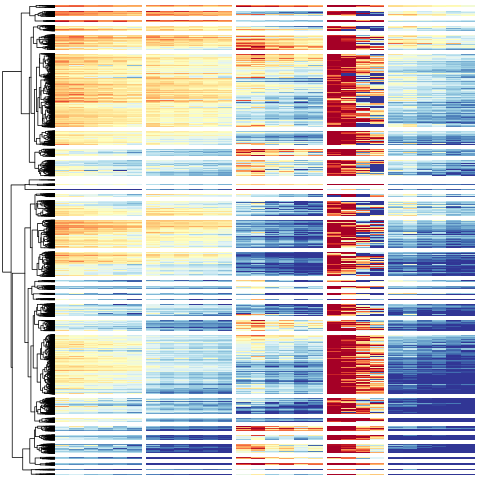

In [20]:
%%R

# Set colorscale: the minimum, the maximum, and the increasing steps (0.04) for the color scale
hlcol_min = 5
hlcol_max = 300
breaksList = seq(log(hlcol_min), log(hlcol_max), by = 0.04)
# Cluster annotation colormap
anno_cmap = colorRampPalette(grDevices::rainbow(N_ok_clust)) 
anno_colors <- anno_cmap(N_ok_clust)
names(anno_colors) <- unique(dr$Cluster)
anno_colors <- list(Cluster=anno_colors)

filename = paste0('Cluster_R_',rt,o,'.pdf')

#plot final heatmap
ph <- pheatmap(dplot_clust, 
         cluster_rows = hc_order, 
         cluster_cols = FALSE,
         color = colorRampPalette(brewer.pal(n = 11, name = 'RdYlBu'))(length(breaksList)),
         breaks = breaksList,
         border_color = NA,
         show_rownames = FALSE,
         show_colnames = FALSE,
#          annotation_row = dr['Cluster'],#uncomment for colored cluster column
#          annotation_colors = anno_colors,#uncomment for colored cluster column
         annotation_names_row = FALSE,
#          gaps_row=c(),#does not work when rows are clustered: instead use cutree_rows
         gaps_col=c(6,12,18,22),#c(6,12,18,24,30,36)#
         cutree_rows = N_ok_clust,#gives spaces between clusters
         annotation_legend = FALSE,
         legend=FALSE,#####Set to TRUE for legend
         legend_breaks = c(log(hlcol_min), log(7.5), log(15), log(30), log(60), 
                           log(120), log(240), log(hlcol_max)),
         legend_labels = c(hlcol_min, 7.5, 15, 30, 60, 120, 240, hlcol_max),
#          row_split = 2,# does not work
#          cellheight = 6,#autoscale is much better...
#          cellwidth = 20,#not used
#          fontsize_col = 6,#not used
#          main="Genes clustered by RNA flow half lives",#title, not used
               
#          filename = paste0(path,"/",filename), #############################   UNCOMMENT TO SAVE AS PDF #
         width = 6, height = 20)#does not work in jupyter visualization, only for pdf


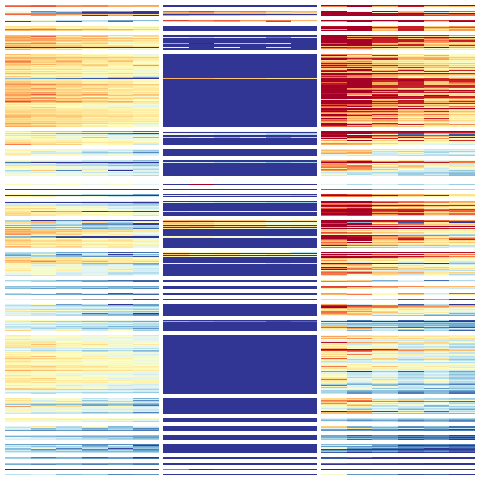

In [21]:
%%R

filename = paste0('Cluster_R_',rt,o,'_derived_rates.pdf')

#plot final heatmap
ph <- pheatmap(dplot_deriv, 
         cluster_rows = hc_order,
         cluster_cols = FALSE,
         color = colorRampPalette(brewer.pal(n = 11, name = 'RdYlBu'))(length(breaksList)),
         breaks = breaksList,
         border_color = NA,
         show_rownames = FALSE,
         show_colnames = FALSE,
         annotation_names_row = FALSE,
         gaps_col=c(6,12),
         treeheight_row = 0,
         cutree_rows = N_ok_clust,#gives spaces between clusters
         annotation_legend = FALSE,
         legend=FALSE,#####Set to TRUE for legend
               
#          filename = paste0(path,"/",filename), #############################   UNCOMMENT TO SAVE AS PDF #
         width = 3, height = 20)#does not work in jupyter visualization, only for pdf


## Get clustering numbers from R into Python

In [22]:
%%R
#get the R cluster numbers for all gene indexes in original order
orcl <- cutree(hc_order, k=N_ok_clust)

# add the R cluster numbers to your data
dr_fromR <- cbind(dr, ClusterR=orcl)

#reorder data to match the order in the heatmap:
dr_fromR <- dr_fromR[hc_order$order,]

#get heatmap color map to Python
anno_colors <- anno_cmap(N_ok_clust)

In [23]:
# examine the R cluster numbers by order in the R heatmap
%R clusterR_order_heatmap = unique(orcl[hc_order$order])

#pass it to Python
%R -o clusterR_order_heatmap 
%R -o dr_fromR 
%R -o anno_colors

In [24]:
map_cl_R2Py = dict()
map_cl_Py2R = dict()
map_cl_R2Heatmaprank = dict()

for i, clR in enumerate(dr_fromR['ClusterR'].unique()):
    clPy = dr_fromR['Cluster'].unique()[i]
    map_cl_R2Py[clR] = clPy
    map_cl_Py2R[clPy] = clR
    map_cl_R2Heatmaprank[clR] = i+1

In [25]:
for cl in range(N_clust):
    if cl in map_cl_Py2R.keys():
        logger.info(['py:',cl,
          'R cluster:', map_cl_Py2R[cl], 
          'rank heatmap:', clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl])+1 ])

INFO: [2023-04-01 14:45:24] Function - ['py:', 2, 'R cluster:', 17, 'rank heatmap:', 29]
INFO: [2023-04-01 14:45:24] Function - ['py:', 3, 'R cluster:', 27, 'rank heatmap:', 30]
INFO: [2023-04-01 14:45:24] Function - ['py:', 4, 'R cluster:', 5, 'rank heatmap:', 28]
INFO: [2023-04-01 14:45:24] Function - ['py:', 5, 'R cluster:', 7, 'rank heatmap:', 27]
INFO: [2023-04-01 14:45:24] Function - ['py:', 6, 'R cluster:', 10, 'rank heatmap:', 26]
INFO: [2023-04-01 14:45:24] Function - ['py:', 9, 'R cluster:', 24, 'rank heatmap:', 32]
INFO: [2023-04-01 14:45:24] Function - ['py:', 10, 'R cluster:', 20, 'rank heatmap:', 31]
INFO: [2023-04-01 14:45:24] Function - ['py:', 11, 'R cluster:', 32, 'rank heatmap:', 12]
INFO: [2023-04-01 14:45:24] Function - ['py:', 12, 'R cluster:', 31, 'rank heatmap:', 10]
INFO: [2023-04-01 14:45:24] Function - ['py:', 13, 'R cluster:', 22, 'rank heatmap:', 8]
INFO: [2023-04-01 14:45:24] Function - ['py:', 14, 'R cluster:', 29, 'rank heatmap:', 11]
INFO: [2023-04-01 1

### Write hierarchically clustered data to file

In [26]:
dr_fromR['Cluster_heatmap'] = dr_fromR['ClusterR'].map(map_cl_R2Heatmaprank)
dr_fromR.drop(['Cluster','ClusterR'], axis=1, inplace=True)

filename = 'Cluster_R_'+rt+o+'.tsv'
# dr_fromR.to_csv(os.path.join(path, filename), sep='\t')

# GO enrichment analysis with GOAtools

source: https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102.ipynb

#in terminal in `O2/GO/bseq` folder only once:
#wget http://purl.obolibrary.org/obo/go.obo
#wget ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz

In [79]:
#Load GO OBO and (human) gene annotations
path_go_obo = os.path.join('/n','groups','churchman','ri23','GO','bseq')
filename = 'go.obo'
go_dag = GODag(os.path.join(path_go_obo,filename))

#load human annotation files
filename = 'gene2go'
filename_gene2go = download_ncbi_associations(gene2go=os.path.join(path_go_obo,filename))

objanno = dict()
ns2assoc = dict()
for o in organisms: 
    logger.info(o)
    # Read NCBI's gene2go. Store annotations in a list of namedtuples
    objanno[o] = Gene2GoReader(filename_gene2go, taxids=[org_id_map[o]])

    # Get namespace2association where:
    #    namespace is:
    #        BP: biological_process               
    #        MF: molecular_function
    #        CC: cellular_component
    #    assocation is a dict:
    #        key: NCBI (Entrez) GeneID
    #        value: A set of GO IDs associated with that gene

    ns2assoc[o] = objanno[o].get_ns2assc()
    
    for nspc, id2gos in ns2assoc[o].items():
        logger.info("{NS} {N:,} annotated genes".format(NS=nspc, N=len(id2gos)))

/n/groups/churchman/ri23/GO/bseq/go.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms
  EXISTS: /n/groups/churchman/ri23/GO/bseq/gene2go


INFO: [2023-03-31 12:28:37] Function - m


HMS:0:00:14.538473 419,975 annotations, 29,776 genes, 18,911 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 


INFO: [2023-03-31 12:28:52] Function - BP 18,633 annotated genes
INFO: [2023-03-31 12:28:52] Function - CC 19,352 annotated genes
INFO: [2023-03-31 12:28:52] Function - MF 17,429 annotated genes
INFO: [2023-03-31 12:28:52] Function - h


HMS:0:00:10.647594 335,439 annotations, 20,702 genes, 18,739 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 


INFO: [2023-03-31 12:29:04] Function - BP 18,569 annotated genes
INFO: [2023-03-31 12:29:04] Function - CC 19,473 annotated genes
INFO: [2023-03-31 12:29:04] Function - MF 18,227 annotated genes


In [80]:
###get gene_mapper file so that you can map ENSG to Entrez gene IDs used for GO enrichment analysis
def get_hgnc(resource_folder):
    fname = os.path.join(resource_folder, 'hgnc_entries.tsv')
    if not os.path.exists(fname):
        # Select relevant columns and parameters
        cols = ['gd_hgnc_id', 'gd_app_sym', 'gd_app_name', 'gd_prev_sym',
                'gd_status', 'md_eg_id', 'md_prot_id', 'md_mgd_id',
                'md_rgd_id', 'gd_pub_ensembl_id']
        statuses = ['Approved', 'Entry%20Withdrawn']
        params = {
            'hgnc_dbtag': 'on',
            'order_by': 'gd_app_sym_sort',
            'format': 'text',
            'submit': 'submit'
        }

        # Construct a download URL from the above parameters
        url = 'https://www.genenames.org/cgi-bin/download/custom?'
        url += '&'.join(['col=%s' % c for c in cols]) + '&'
        url += '&'.join(['status=%s' % s for s in statuses]) + '&'
        url += '&'.join(['%s=%s' % (k, v) for k, v in params.items()])

        # Save the download into a file
        urllib.request.urlretrieve(url, fname)
    return fname

gene_map = dict()

#Human
filename_hgnc = get_hgnc(path_go_obo)
gene_map['h'] = pd.read_csv(filename_hgnc, sep='\t')
col_map = {'HGNC ID': 'hgnc_id',
           'Approved symbol': 'Symbol',
           'Previous symbols': 'old_symbol',
           'NCBI Gene ID(supplied by NCBI)': 'entrez_id',
           'UniProt ID(supplied by UniProt)':'up_id',
           'Mouse genome database ID(supplied by MGI': 'mgi_id',
           'Rat genome database ID(supplied by RGD)': 'rgd_id',
           'Ensembl gene ID': 'ens_id'}
gene_map['h'].rename(mapper=col_map, axis=1, inplace=True) 

#Mouse
filename_hgnc = os.path.join('/n','groups','churchman','ri23','GO','bseq','Mouse_ens_entrez_map.csv')
gene_map['m'] = pd.read_csv(filename_hgnc, sep=',',dtype={'entrezgene_id': str})
col_map = {'ensembl_gene_id':'ens_id',
           'mgi_symbol':'Symbol',
           'entrezgene_id':'entrez_id'}
gene_map['m'].rename(mapper=col_map, axis=1, inplace=True) 
gene_map['m'] = gene_map['m'][~gene_map['m']['entrez_id'].isna()]

In [82]:
o = 'h'

#Get universe of genes (entrez_ids) for enrichment analysis
gene_universe = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

alpha_fdr = 0.05 / N_ok_clust

#Initialize a GOEA object
goeaobj = GOEnrichmentStudyNS(gene_universe, # universe List of protein-coding genes
                              ns2assoc[o], #geneid/GO associations (from NCBI gene)
                              go_dag, # Ontologies
                              propagate_counts = True,#default True: parental GOannos are also annotations 
                              alpha = alpha_fdr, # default significance cut-off
                              methods = ['fdr_bh']) # default multiple test correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


4 GO IDs NOT FOUND IN ASSOCIATION: GO:0036404 GO:2001216 GO:0001207 GO:0033168


 90%  9,601 of 10,677 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95% 10,094 of 10,677 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493


 93%  9,978 of 10,677 population items found in association


## Run enrichment analysis

'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.  
"e" in the "Enrichment" column means "enriched" - the concentration of GO term in the study group is significantly higher than those in the population.  
"p" stands for "purified" - significantly lower concentration of the GO term in the study group than in the population.
https://github.com/tanghaibao/goatools

To get the genes corresponding to an enriched GO term, see GOEnrichmentRecord object description:
https://github.com/tanghaibao/goatools/blob/main/goatools/go_enrichment.py

GOEnrichmentRecord.study_items = annotated genes in NCBI IDs

In [182]:
#Run enrichment analysis

goea_results_all = dict()

for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    
    logger.info('rank %d cluster R heatmap: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))

    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    logger.info('N_genes in cluster: %d' % len(cluster_genes))
    logger.info(list(gene_map[o][gene_map[o]['ens_id'].isin(cluster_genes)].sort_values(by='Symbol')['Symbol']))
    geneids_study = list(gene_map[o][gene_map[o]['ens_id'].isin(cluster_genes)]['entrez_id'].astype(int))

    goea_results_all[cl] = goeaobj.run_study(geneids_study)#, prt=None)

INFO: [2023-03-31 14:00:42] Function - rank 1 cluster R heatmap: 21 (py:70)
INFO: [2023-03-31 14:00:42] Function - N_genes in cluster: 71
INFO: [2023-03-31 14:00:42] Function - ['ARRDC3', 'BAMBI', 'BTG2', 'CASS4', 'CD69', 'CDK5R1', 'CISH', 'CITED2', 'CSRNP1', 'CXCL2', 'DDIT4', 'DNAJB9', 'DUSP1', 'DYNLT2', 'EGR1', 'FAM83D', 'FBXO5', 'FOSL1', 'GADD45A', 'GDF15', 'H2AC18', 'H3C14', 'HAUS8', 'HES1', 'ID1', 'ID2', 'IER3', 'IER5', 'JUNB', 'KBTBD8', 'KCNJ8', 'KLF10', 'KLF11', 'KLF6', 'LDLR', 'LRP12', 'MYC', 'MYLIP', 'NFKBIA', 'PCGF1', 'PLEKHO2', 'PPP1R15A', 'RPL38', 'RPS27', 'RPS29', 'SERTAD3', 'SGK1', 'SIK1', 'SLC25A25', 'SNAI1', 'SOCS1', 'SOCS3', 'SPRY2', 'SPRY4', 'SSBP1', 'TGIF1', 'TRIB1', 'TXNIP', 'ZC3H12A', 'ZFP36', 'ZFP36L1', 'ZFP36L2', 'ZNF217', 'ZNF296', 'ZNF367', 'ZNF526', 'ZNF551', 'ZNF57', 'ZNF627', 'ZNF669']



Run BP Gene Ontology Analysis: current study set of 70 IDs ... 99%     69 of     70 study items found in association
100%     70 of     70 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   2,167 GO terms are associated with     69 of     70 study items
  METHOD fdr_bh:
     110 GO terms found significant (< 0.0016129032258064516=alpha) (110 enriched +   0 purified): statsmodels fdr_bh
      63 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 70 IDs ...100%     70 of     70 study items found in association
100%     70 of     70 study items found in population(10677)
Calculating 1,783 uncorrected p-values using fisher_scipy_stats
   1,783 GO terms are associated with 10,094 of 10,677 population items
     214 GO terms are associated 

INFO: [2023-03-31 14:00:53] Function - rank 2 cluster R heatmap: 25 (py:46)
INFO: [2023-03-31 14:00:53] Function - N_genes in cluster: 150
INFO: [2023-03-31 14:00:53] Function - ['ABCF3', 'ABHD11', 'ABHD14A-ACY1', 'ACY1', 'ALKBH6', 'ARIH2OS', 'ATP5F1E', 'ATP5MC1', 'ATP5MF', 'ATP5PD', 'ATP6V1FNB', 'ATXN7L2', 'BAG1', 'BOLA3', 'C15orf61', 'C19orf73', 'C1QTNF6', 'CCDC12', 'CCZ1', 'CHRNA10', 'CLASRP', 'CLK3', 'CLK4', 'CMC1', 'CNOT3', 'CNTF', 'COQ6', 'COX19', 'COX5B', 'DNAJB5', 'DNAJC2', 'DUSP28', 'EED', 'EEF1B2', 'EIF2B4', 'EMC9', 'ETAA1', 'FAH', 'FAM162A', 'FIBP', 'FRS3', 'FSCN3', 'GRHPR', 'GSTZ1', 'GTF2IRD2B', 'H3-7', 'HLX', 'HYPK', 'IK', 'ILKAP', 'INKA1', 'IQCG', 'IRF1', 'JMJD4', 'KRTCAP2', 'LAMTOR2', 'LTO1', 'MAPK7', 'MLX', 'MRPL46', 'MRPS15', 'MRPS18C', 'MTX1', 'MVK', 'MZT2A', 'NDUFA3', 'NDUFS8', 'NOP16', 'NOP58', 'NOSIP', 'NPRL2', 'NT5C', 'ORMDL2', 'PDCD5', 'PIP4P1', 'PLEKHO1', 'PLK3', 'POLR1C', 'PPIA', 'PPOX', 'PPP1R14A', 'PPP1R3F', 'PSMC1', 'PSMG4', 'PTBP2', 'RABL2A', 'RBX1', 'RNF18

   4,049 GO terms are associated with  9,978 of 10,677 population items
     277 GO terms are associated with     69 of     70 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 147 IDs ... 87%    128 of    147 study items found in association
100%    147 of    147 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,526 GO terms are associated with    128 of    147 study items
  METHOD fdr_bh:
       9 GO terms found significant (< 0.0016129032258064516=alpha) (  9 enriched +   0 purified): statsmodels fdr_bh
      38 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:01:05] Function - rank 3 cluster R heatmap: 30 (py:45)
INFO: [2023-03-31 14:01:05] Function - N_genes in cluster: 36
INFO: [2023-03-31 14:01:05] Function - ['ATP5MC3', 'EEF1A1', 'EIF3K', 'EIF4A3', 'EXOSC4', 'GPATCH4', 'H3C15', 'IMPDH2', 'NTMT1', 'PSMB4', 'PSMC5', 'PSMD6', 'PSMD9', 'RPL10A', 'RPL13', 'RPL27', 'RPL4', 'RPL6', 'RPL7A', 'RPLP0', 'RPLP1', 'RPS14', 'RPS15', 'RPS17', 'RPS19BP1', 'RPS27A', 'RPS3', 'RTRAF', 'SRSF7', 'TBCE', 'TFAP4', 'TKT', 'U2AF1', 'UBE2S', 'YDJC']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     381 GO terms are associated with    141 of    147 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0016129032258064516=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      44 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 35 IDs ... 97%     34 of     35 study items found in association
100%     35 of     35 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     769 GO terms are associated with     34 of     35 study items
  METHOD fdr_bh:
      17 GO terms found significant (< 0.0016129032258064516=alpha) ( 17 enriched +   0 purified): statsmodels fdr_bh
      22 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:01:15] Function - rank 4 cluster R heatmap: 16 (py:43)
INFO: [2023-03-31 14:01:15] Function - N_genes in cluster: 159
INFO: [2023-03-31 14:01:15] Function - ['ADAT3', 'ADM2', 'ADM5', 'AGFG2', 'AJUBA', 'ANKRD13D', 'ARL11', 'ASTE1', 'B3GALT4', 'C17orf67', 'C19orf44', 'C1orf116', 'C1orf35', 'C21orf58', 'C2orf42', 'C3orf62', 'CACNB3', 'CBWD2', 'CBWD3', 'CBWD5', 'CCDC142', 'CCM2', 'CCNE2', 'CDC37L1', 'CDC42EP2', 'CDK20', 'COX17', 'CRTC2', 'DBP', 'DCP1A', 'DDR2', 'DEPDC5', 'DGKA', 'DHX35', 'DNM1', 'DPF1', 'EIF4ENIF1', 'ELMOD3', 'ETV3', 'FAM124B', 'FAM214B', 'FASTK', 'FBXO48', 'FHIP2A', 'FOXD4L1', 'FRA10AC1', 'GAD1', 'GALT', 'GPR75', 'GTF2IRD2', 'HECTD2', 'HOXB5', 'HSF2', 'ILVBL', 'INPP5E', 'ITGB1BP2', 'KCTD11', 'KCTD6', 'KLF15', 'LENG1', 'LRRC37A', 'MAGI2', 'MAMSTR', 'MAP1S', 'MAP4K3', 'MCOLN1', 'METTL22', 'MIEF2', 'MISP3', 'MITD1', 'MORN1', 'MUTYH', 'NAGK', 'NBPF11', 'NBPF12', 'NCK1', 'NDUFB2', 'NOL12', 'OR2B6', 'OTX1', 'P2RX4', 'P2RY11', 'PANK1', 'PARP6', 'PARS2', 'PCS

   4,049 GO terms are associated with  9,978 of 10,677 population items
     198 GO terms are associated with     35 of     35 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.0016129032258064516=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 154 IDs ... 83%    128 of    154 study items found in association
100%    154 of    154 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,830 GO terms are associated with    128 of    154 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:01:27] Function - rank 5 cluster R heatmap: 18 (py:41)
INFO: [2023-03-31 14:01:27] Function - N_genes in cluster: 440
INFO: [2023-03-31 14:01:27] Function - ['ABHD5', 'ADO', 'AEN', 'AKR1A1', 'ALKBH4', 'AMMECR1L', 'AOC2', 'ARL4A', 'ASB7', 'ATF3', 'ATF4', 'ATG16L1', 'ATXN1L', 'ATXN7', 'AXIN2', 'B3GNT2', 'BANP', 'BATF2', 'BBC3', 'BBS12', 'BCDIN3D', 'BCL2L11', 'BCL6B', 'BCOR', 'BFAR', 'BHLHE40', 'BLOC1S3', 'BMT2', 'BRD2', 'BRF2', 'BTG3', 'C10orf71', 'C15orf39', 'C16orf91', 'C18orf25', 'C1orf74', 'C20orf204', 'C2CD2L', 'C2orf69', 'C7orf25', 'CBX4', 'CBX8', 'CCDC121', 'CCDC174', 'CCDC71L', 'CCNL1', 'CCNT2', 'CDKN1B', 'CDKN2AIP', 'CDKN2D', 'CENPBD1P', 'CHAC1', 'CHST14', 'CLK1', 'CLP1', 'CMTR2', 'CNEP1R1', 'CPEB2', 'CSKMT', 'CYB561D1', 'DCUN1D3', 'DDIT3', 'DDX20', 'DDX28', 'DHFR2', 'DIPK2A', 'DNAJB1', 'DNAJC16', 'DNAJC27', 'DOLK', 'DPF3', 'DUSP10', 'DUSP14', 'EID2B', 'EIF1AD', 'EIF2AK3', 'EIF4A2', 'EN1', 'ENC1', 'EPC1', 'ERLIN1', 'ETS2', 'EXOC8', 'FADD', 'FAM110A', 'FAM200

   4,049 GO terms are associated with  9,978 of 10,677 population items
     462 GO terms are associated with    144 of    154 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0016129032258064516=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 433 IDs ... 90%    390 of    433 study items found in association
100%    433 of    433 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,770 GO terms are associated with    390 of    433 study items
  METHOD fdr_bh:
      38 GO terms found significant (< 0.0016129032258064516=alpha) ( 31 enriched +   7 purified): statsmodels fdr_bh
     331 study items associated with significant GO IDs (enriched)
     2

INFO: [2023-03-31 14:01:44] Function - rank 6 cluster R heatmap: 2 (py:40)
INFO: [2023-03-31 14:01:44] Function - N_genes in cluster: 2205
INFO: [2023-03-31 14:01:44] Function - ['AARSD1', 'AASDH', 'ABCD4', 'ABHD13', 'ABHD16A', 'ABHD17B', 'ABHD4', 'ABL2', 'ABRAXAS2', 'ABT1', 'ACBD3', 'ACBD5', 'ACVR1B', 'ADPRM', 'ADPRS', 'AEBP2', 'AFF4', 'AFG1L', 'AFTPH', 'AGAP3', 'AGPAT4', 'AHDC1', 'AIFM2', 'AIMP2', 'AKAP10', 'AKAP17A', 'AKAP8', 'AKAP8L', 'AKIRIN1', 'AKIRIN2', 'AKT1S1', 'AKTIP', 'ALAS1', 'ALG2', 'ALG3', 'ALKBH1', 'ALKBH2', 'ALKBH8', 'AMACR', 'AMBRA1', 'AMHR2', 'AMIGO2', 'ANGPT1', 'ANKLE2', 'ANKRA2', 'ANKRD13C', 'ANKRD34A', 'ANKRD40', 'ANKRD46', 'ANKRD49', 'ANKRD50', 'ANKS3', 'ANKZF1', 'ANXA11', 'AP1AR', 'AP3M2', 'AP5B1', 'AP5S1', 'APAF1', 'APBA3', 'APEX2', 'APOBEC3G', 'APTX', 'ARF5', 'ARFRP1', 'ARHGAP11A', 'ARHGAP17', 'ARHGAP24', 'ARHGAP25', 'ARHGAP42', 'ARHGEF2', 'ARHGEF7', 'ARID1A', 'ARID4A', 'ARID4B', 'ARID5A', 'ARID5B', 'ARIH1', 'ARL14EP', 'ARL2', 'ARL5B', 'ARL8A', 'ARMC7', 'ARMC8'

   4,049 GO terms are associated with  9,978 of 10,677 population items
     671 GO terms are associated with    412 of    433 study items
  METHOD fdr_bh:
      22 GO terms found significant (< 0.0016129032258064516=alpha) ( 22 enriched +   0 purified): statsmodels fdr_bh
     284 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2156 IDs ... 90%  1,939 of  2,156 study items found in association
100%  2,156 of  2,156 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   7,477 GO terms are associated with  1,939 of  2,156 study items
  METHOD fdr_bh:
      51 GO terms found significant (< 0.0016129032258064516=alpha) ( 37 enriched +  14 purified): statsmodels fdr_bh
   1,511 study items associated with significant GO IDs (enriched)
     

INFO: [2023-03-31 14:02:19] Function - rank 7 cluster R heatmap: 13 (py:19)
INFO: [2023-03-31 14:02:19] Function - N_genes in cluster: 425
INFO: [2023-03-31 14:02:19] Function - ['AACS', 'ACSF3', 'AFF1', 'ALX4', 'AMPD3', 'ANAPC1', 'ANKFY1', 'ANKRD12', 'ANKRD27', 'ANKRD28', 'ANKRD9', 'AP4E1', 'APOC1', 'AQP10', 'ARFGEF2', 'ARID1B', 'ARID3B', 'ARIH2', 'ARPC4', 'ATP13A1', 'ATR', 'AURKC', 'AZIN1', 'B3GNT9', 'BCL2L12', 'BCL2L2', 'BCL7C', 'BCLAF1', 'BMS1', 'BOD1L1', 'BRD4', 'BRD9', 'BRMS1', 'BSDC1', 'C16orf46', 'C5orf22', 'CACTIN', 'CAPN2', 'CASC3', 'CASKIN2', 'CASZ1', 'CBX7', 'CCAR1', 'CCDC134', 'CCDC88A', 'CCDC88C', 'CCHCR1', 'CCND3', 'CD37', 'CDC6', 'CDCA7', 'CDK2AP2', 'CDK7', 'CENPA', 'CEP57', 'CFAP298', 'CHAF1A', 'CHMP4C', 'CHST12', 'CIAO1', 'CLBA1', 'CLN6', 'CLSPN', 'COG5', 'CORO2A', 'CPSF6', 'CRACR2A', 'CT45A3', 'CTDP1', 'CTPS1', 'CYBA', 'CYC1', 'CYTH2', 'DAP3', 'DCXR', 'DDB1', 'DDX10', 'DDX23', 'DDX31', 'DDX39B', 'DDX3X', 'DDX5', 'DDX53', 'DDX56', 'DGCR8', 'DHH', 'DIS3', 'DOP1A', 'DOT

   4,049 GO terms are associated with  9,978 of 10,677 population items
   1,732 GO terms are associated with  2,028 of  2,156 study items
  METHOD fdr_bh:
      33 GO terms found significant (< 0.0016129032258064516=alpha) ( 21 enriched +  12 purified): statsmodels fdr_bh
   1,221 study items associated with significant GO IDs (enriched)
     176 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 417 IDs ... 92%    384 of    417 study items found in association
100%    417 of    417 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,655 GO terms are associated with    384 of    417 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0016129032258064516=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      74 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:02:37] Function - rank 8 cluster R heatmap: 22 (py:13)
INFO: [2023-03-31 14:02:37] Function - N_genes in cluster: 214
INFO: [2023-03-31 14:02:37] Function - ['ABL1', 'ABO', 'ACER2', 'ADAMTS3', 'ADGRE5', 'ADORA2B', 'ALDH1B1', 'ANKRD11', 'ANKRD33B', 'ANTXR2', 'APBB2', 'APC', 'APOBR', 'ARHGAP11B', 'ATAD5', 'ATP6V0E1', 'BACH1', 'C1orf226', 'C3AR1', 'CCDC126', 'CCDC144NL', 'CD83', 'CDRT4', 'CEMIP2', 'CEP295', 'CHD6', 'CHD8', 'CHIC2', 'CHST10', 'CHST11', 'CHST2', 'CHSY1', 'CLPTM1', 'CMPK2', 'CMTM6', 'CNNM2', 'CNNM4', 'CNR1', 'CSGALNACT2', 'CTIF', 'DAG1', 'DCHS2', 'DDR1', 'DEGS1', 'DERL1', 'DHRS3', 'DPP3', 'EEF1AKMT4-ECE2', 'EFNB1', 'EMC1', 'ESRRB', 'EZH1', 'F2R', 'FAF2', 'FAM156B', 'FBXO34', 'FBXO46', 'FGFRL1', 'FKBP7', 'FNTB', 'FRRS1', 'FUT10', 'GBA', 'GLCE', 'GON4L', 'GPRC5B', 'GRIN2D', 'GXYLT1', 'H1-3', 'H2AW', 'H3C7', 'H4C1', 'H4C11', 'H4C2', 'HMGCR', 'HMMR', 'HS3ST3A1', 'HS6ST1', 'HSPA13', 'HSPA6', 'IFNAR2', 'IL15RA', 'ITPR1', 'JARID2', 'JMJD1C', 'KCNJ11', 'KIAA2013

   4,049 GO terms are associated with  9,978 of 10,677 population items
     828 GO terms are associated with    400 of    417 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0016129032258064516=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
     165 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 210 IDs ... 89%    186 of    210 study items found in association
100%    210 of    210 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,344 GO terms are associated with    186 of    210 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      53 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:02:51] Function - rank 9 cluster R heatmap: 4 (py:21)
INFO: [2023-03-31 14:02:51] Function - N_genes in cluster: 466
INFO: [2023-03-31 14:02:51] Function - ['AARS2', 'ABCA3', 'ABCA7', 'ABCC5', 'ACHE', 'ACSL3', 'ACSL4', 'ACTR3C', 'ADAM8', 'ADAMTS14', 'ADAT2', 'ADCY7', 'ADGRD1', 'ADPGK', 'AGAP4', 'AGAP6', 'AGAP9', 'AGPAT2', 'AGPAT5', 'AIG1', 'AKAP11', 'AKAP13', 'ALG1', 'ALG10B', 'ALG12', 'ALG14', 'ALG6', 'AMIGO1', 'AMIGO3', 'AMOTL1', 'ANKMY1', 'ANKRD10', 'ANKRD18B', 'ANO7', 'APLNR', 'ARAP1', 'ARAP3', 'ARFIP1', 'ARHGEF3', 'ARL13B', 'ARL17A', 'ARL17B', 'ARL6IP6', 'ARSK', 'ASCC1', 'ASH1L', 'ASIC4', 'ASPH', 'ATAT1', 'ATE1', 'ATP6AP1', 'ATP6V0A1', 'B3GALNT2', 'B4GALNT1', 'BCL2', 'BCL9L', 'BMF', 'BMP1', 'BMPR2', 'BRCA2', 'BRINP3', 'BRIP1', 'BTBD9', 'BTN3A1', 'BTNL9', 'C14orf93', 'C15orf62', 'C17orf99', 'C1orf198', 'C5orf63', 'C6orf62', 'CAPRIN2', 'CBARP', 'CC2D1A', 'CCDC18', 'CCNH', 'CCNL2', 'CD22', 'CD226', 'CD46', 'CD47', 'CD58', 'CDK10', 'CENATAC', 'CEP152', 'CEP162', '

   4,049 GO terms are associated with  9,978 of 10,677 population items
     730 GO terms are associated with    195 of    210 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.0016129032258064516=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      46 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 445 IDs ... 85%    378 of    445 study items found in association
100%    445 of    445 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   4,116 GO terms are associated with    378 of    445 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
     1

INFO: [2023-03-31 14:03:10] Function - rank 10 cluster R heatmap: 31 (py:12)
INFO: [2023-03-31 14:03:10] Function - N_genes in cluster: 5
INFO: [2023-03-31 14:03:10] Function - ['ANP32D', 'DNAAF9', 'IER2', 'POTEG']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     947 GO terms are associated with    394 of    445 study items
  METHOD fdr_bh:
       9 GO terms found significant (< 0.0016129032258064516=alpha) (  3 enriched +   6 purified): statsmodels fdr_bh
      35 study items associated with significant GO IDs (enriched)
     355 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 25%      1 of      4 study items found in association
100%      4 of      4 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
      48 GO terms are associated with      1 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2023-03-31 14:03:19] Function - rank 11 cluster R heatmap: 29 (py:14)
INFO: [2023-03-31 14:03:19] Function - N_genes in cluster: 44
INFO: [2023-03-31 14:03:19] Function - ['B3GNT5', 'C1orf43', 'CDKN2C', 'CENPB', 'DNTTIP2', 'GLUD2', 'H1-10', 'H1-2', 'H1-4', 'H1-5', 'H2AC12', 'H2AC16', 'H2AC17', 'H2AC19', 'H2AC20', 'H2AC21', 'H2AC4', 'H2AC7', 'H2AC8', 'H2BC13', 'H2BC4', 'H3-5', 'H3C12', 'H4C3', 'H4C4', 'HNRNPCL1', 'HNRNPF', 'HSPA1A', 'HSPA5', 'ICMT', 'NR2F6', 'PDPR', 'SDF2L1', 'SLC20A1', 'SLC23A2', 'SRPRB', 'TMED9', 'TMEM9', 'TMEM97', 'TMEM9B', 'TUBB2A', 'UBC', 'WDR74']


   4,049 GO terms are associated with  9,978 of 10,677 population items
       7 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 43 IDs ... 77%     33 of     43 study items found in association
100%     43 of     43 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     777 GO terms are associated with     33 of     43 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.0016129032258064516=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
       9 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:03:28] Function - rank 12 cluster R heatmap: 32 (py:11)
INFO: [2023-03-31 14:03:28] Function - N_genes in cluster: 5
INFO: [2023-03-31 14:03:28] Function - ['EDARADD', 'MTRNR2L10', 'MTRNR2L12', 'MTRNR2L4', 'POTEJ']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     170 GO terms are associated with     42 of     43 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.0016129032258064516=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      21 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
      32 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0016129032258064516=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0

INFO: [2023-03-31 14:03:36] Function - rank 13 cluster R heatmap: 28 (py:17)
INFO: [2023-03-31 14:03:36] Function - N_genes in cluster: 93
INFO: [2023-03-31 14:03:36] Function - ['ABCA13', 'ADAM15', 'ADAMTSL4', 'ADSS1', 'AGAP5', 'AGER', 'ANKRD23', 'ANKRD36', 'ANKRD36B', 'APPL2', 'ARMC5', 'B3GNTL1', 'BCLAF3', 'C1RL', 'CARD8', 'CARD9', 'CCDC150', 'CCDC180', 'CCDC24', 'CEP83', 'CHEK2', 'CHKB-CPT1B', 'CNKSR1', 'CNNM3', 'COG7', 'CROCC', 'CRTC1', 'CYB561D2', 'CYB5D2', 'DOCK4', 'DOK4', 'ENO3', 'FAM184A', 'FBF1', 'GLYCTK', 'GPR108', 'HCLS1', 'HCN3', 'HELZ2', 'HOOK2', 'IL11RA', 'INTS6L', 'KATNIP', 'KCNN1', 'L3MBTL1', 'MAN1B1', 'NDST2', 'NEK11', 'NIPSNAP3B', 'NOD1', 'NOTUM', 'NPIPA1', 'PAK6', 'PIBF1', 'PIK3C2B', 'PLA2G4B', 'PLOD3', 'PRRT1', 'RFT1', 'RYR1', 'SAT2', 'SH3BP2', 'SLC12A9', 'SLC2A4', 'SLC66A1', 'SORBS1', 'SULT1A2', 'TARS3', 'TBCEL', 'TBX19', 'TCAP', 'TEN1-CDK3', 'TEPSIN', 'TMEM25', 'TMEM255B', 'TMEM67', 'TNS1', 'TRIP4', 'VAMP1', 'XKR3', 'ZNF235', 'ZNF559', 'ZNF674', 'ZNF688', 'ZNF718'

   4,049 GO terms are associated with  9,978 of 10,677 population items
       8 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0016129032258064516=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 86 IDs ... 84%     72 of     86 study items found in association
100%     86 of     86 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,596 GO terms are associated with     72 of     86 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:03:47] Function - rank 14 cluster R heatmap: 3 (py:18)
INFO: [2023-03-31 14:03:47] Function - N_genes in cluster: 463
INFO: [2023-03-31 14:03:47] Function - ['AAAS', 'ABCB6', 'ABCC10', 'ACAD11', 'ACAD8', 'ACBD4', 'ACBD6', 'ADAMTSL5', 'AIFM1', 'AKNA', 'AKT2', 'AMDHD2', 'ANAPC5', 'ANGEL2', 'ANKIB1', 'ANKLE1', 'ANKRD39', 'AP2A1', 'AP4B1', 'AP4M1', 'AP5Z1', 'APBB3', 'ARHGAP21', 'ARHGEF1', 'ARHGEF25', 'ARL16', 'ARRDC1', 'ASAH2B', 'ASL', 'ASPSCR1', 'ATAD3B', 'ATG7', 'ATM', 'B3GNT4', 'B4GALT2', 'B4GALT7', 'BAIAP2L1', 'BBS1', 'BCS1L', 'BDH2', 'BLZF1', 'BORCS8', 'BRAT1', 'BRF1', 'BRICD5', 'C11orf21', 'C16orf95', 'C18orf54', 'C19orf25', 'C1orf112', 'C2CD3', 'C2orf68', 'C2orf92', 'C9orf72', 'C9orf85', 'CA13', 'CALML4', 'CARD19', 'CASP8', 'CCDC163', 'CCDC7', 'CCDC82', 'CD33', 'CDC42BPG', 'CDK11A', 'CELSR3', 'CEP135', 'CEP63', 'CES3', 'CFAP119', 'CFAP410', 'CHD1L', 'CHFR', 'CHKB', 'CHMP6', 'CIAO3', 'CKLF', 'CLDN15', 'CNTROB', 'COA1', 'COA5', 'COBLL1', 'COMMD4', 'COPE', 'CORO1B'

   4,049 GO terms are associated with  9,978 of 10,677 population items
     339 GO terms are associated with     77 of     86 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 455 IDs ... 86%    392 of    455 study items found in association
100%    455 of    455 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,813 GO terms are associated with    392 of    455 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:04:04] Function - rank 15 cluster R heatmap: 8 (py:48)
INFO: [2023-03-31 14:04:04] Function - N_genes in cluster: 832
INFO: [2023-03-31 14:04:04] Function - ['AASDHPPT', 'ABI2', 'ACAA1', 'ACADM', 'ACADSB', 'ACD', 'ACOT8', 'ACTL6A', 'ACTR10', 'ADAL', 'ADRM1', 'ADSL', 'ADSS2', 'AFMID', 'AGBL5', 'AGFG1', 'AGGF1', 'AGK', 'AGO2', 'AGO3', 'AHSA1', 'AMPD2', 'ANAPC11', 'ANAPC7', 'ANKRD13A', 'ANKRD16', 'ANKRD54', 'ANXA1', 'AP1M1', 'AP2S1', 'AP3S2', 'AP5M1', 'APOBEC3D', 'APOBEC3F', 'ARFGAP2', 'ARFIP2', 'ARHGAP1', 'ARHGAP12', 'ARHGEF19', 'ARHGEF39', 'ARMCX5', 'ARPC5', 'ARRB1', 'ASAP2', 'ASAP3', 'ASRGL1', 'ATF7IP2', 'ATG2B', 'ATG3', 'ATG4B', 'ATIC', 'ATP5IF1', 'ATP5MG', 'ATP5MJ', 'ATP5PO', 'ATP6V0D1', 'ATP6V1B2', 'ATXN3', 'AZI2', 'BAP1', 'BAX', 'BAZ2B', 'BCKDK', 'BECN1', 'BEND7', 'BIRC2', 'BOLA2B', 'BSCL2', 'BTRC', 'BUB1', 'BUD23', 'BUD31', 'BZW2', 'C11orf98', 'C12orf29', 'C12orf73', 'C17orf49', 'C19orf54', 'C1orf174', 'C8orf33', 'C8orf82', 'C9orf78', 'CA8', 'CACUL1', 'CALCOCO

   4,049 GO terms are associated with  9,978 of 10,677 population items
     860 GO terms are associated with    416 of    455 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   2 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      80 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 824 IDs ... 91%    751 of    824 study items found in association
100%    824 of    824 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   5,374 GO terms are associated with    751 of    824 study items
  METHOD fdr_bh:
      14 GO terms found significant (< 0.0016129032258064516=alpha) ( 14 enriched +   0 purified): statsmodels fdr_bh
     498 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:04:26] Function - rank 16 cluster R heatmap: 15 (py:36)
INFO: [2023-03-31 14:04:26] Function - N_genes in cluster: 737
INFO: [2023-03-31 14:04:26] Function - ['AAMP', 'ABCE1', 'ABHD14B', 'ABHD17A', 'ABHD18', 'ABITRAM', 'ACAA2', 'ACAD9', 'ACOX1', 'ACP1', 'ACSBG1', 'ACTR1A', 'ACTR1B', 'ACYP1', 'ADD2', 'ADD3', 'ADIPOR1', 'AGO1', 'AGO4', 'AHCYL1', 'AK2', 'AKIP1', 'AKR1C2', 'AKR7A2', 'ALAD', 'ALDH16A1', 'AMZ2', 'ANKRD13B', 'AP2A2', 'AP2M1', 'AP3M1', 'AP3S1', 'AP4S1', 'APEH', 'APPL1', 'APRT', 'ARFGAP1', 'ARHGAP6', 'ARHGDIA', 'ARL1', 'ARL6IP4', 'ARMC10', 'ARPC1B', 'ARRB2', 'ATG10', 'ATG4C', 'ATP5F1D', 'ATP5MC2', 'ATP5ME', 'ATP5MK', 'ATP6V1F', 'ATP6V1G2-DDX39B', 'ATPAF2', 'AUH', 'B9D1', 'BABAM2', 'BBIP1', 'BBS4', 'BBS7', 'BCCIP', 'BCKDHA', 'BCKDHB', 'BGLAP', 'BIVM-ERCC5', 'BLOC1S1', 'BMI1', 'BNIP3', 'BRCC3', 'BRD7', 'BRI3', 'BTBD2', 'BUB3', 'C17orf75', 'C1D', 'C4orf3', 'C4orf33', 'C8orf88', 'CACYBP', 'CAMKV', 'CAPN1', 'CARM1', 'CARNMT1', 'CARS2', 'CAST', 'CBR4', 'CCDC115',

   4,049 GO terms are associated with  9,978 of 10,677 population items
   1,266 GO terms are associated with    775 of    824 study items
  METHOD fdr_bh:
      15 GO terms found significant (< 0.0016129032258064516=alpha) (  2 enriched +  13 purified): statsmodels fdr_bh
     172 study items associated with significant GO IDs (enriched)
      71 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 729 IDs ... 90%    656 of    729 study items found in association
100%    729 of    729 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   5,109 GO terms are associated with    656 of    729 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:04:48] Function - rank 17 cluster R heatmap: 14 (py:24)
INFO: [2023-03-31 14:04:48] Function - N_genes in cluster: 41
INFO: [2023-03-31 14:04:48] Function - ['ABCA8', 'ACCS', 'ANK3', 'ANKRD36C', 'CALCOCO1', 'CARD18', 'CLEC11A', 'DGAT1', 'EME2', 'FAAP100', 'GPSM1', 'HEXD', 'HYI', 'INVS', 'JMJD7', 'JMJD7-PLA2G4B', 'KIAA0895L', 'KLHL22', 'KREMEN2', 'LAMA5', 'LRRC51', 'MACROD1', 'MAMDC4', 'MFSD14C', 'MICAL1', 'MSH5-SAPCD1', 'PAN2', 'PIDD1', 'PLXND1', 'PRR22', 'S100A1', 'SH3GLB2', 'STK36', 'TCIRG1', 'TERT', 'TRMT11', 'TSPAN32', 'UBXN11', 'VPS13C', 'YJEFN3']


   4,049 GO terms are associated with  9,978 of 10,677 population items
   1,203 GO terms are associated with    690 of    729 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   2 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      22 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 40 IDs ... 85%     34 of     40 study items found in association
100%     40 of     40 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,006 GO terms are associated with     34 of     40 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:05:00] Function - rank 18 cluster R heatmap: 12 (py:25)
INFO: [2023-03-31 14:05:00] Function - N_genes in cluster: 105
INFO: [2023-03-31 14:05:00] Function - ['ABCA2', 'ABHD3', 'ADGRV1', 'ARHGAP4', 'ARPC4-TTLL3', 'ASIC3', 'ATRX', 'BCL6', 'C11orf80', 'C1orf159', 'CAPN15', 'CASKIN1', 'CCDC14', 'CDH12', 'CELSR2', 'CLDN7', 'CSMD1', 'DPP7', 'ERV3-1', 'EVC', 'FAM118A', 'FAM171A2', 'FANCD2', 'GGT1', 'GLIPR1', 'HCN2', 'HIC1', 'HP1BP3', 'HSF4', 'IFT80', 'IGSF10', 'INTS1', 'INTU', 'IQGAP3', 'ITGB3', 'JAG2', 'KCND1', 'KIFC2', 'LAMB2', 'LENG8', 'LYST', 'MAPK8IP3', 'MEGF8', 'MICALL2', 'MMRN2', 'MROH6', 'MYO18A', 'MYO18B', 'MYOM1', 'MYORG', 'NLRP1', 'NOL3', 'NPIPA2', 'NPIPA7', 'NPIPB3', 'NPIPB4', 'NPIPB5', 'NUTM2A', 'OGT', 'OPLAH', 'OR2AG2', 'OR8A1', 'PABPC1L', 'PAX8', 'PCNT', 'PIEZO1', 'PKD1', 'PLCB2', 'PLEKHH2', 'PLXNA1', 'PLXNB1', 'PNISR', 'PTPN23', 'RBM19', 'RGPD5', 'ROBO2', 'RTEL1-TNFRSF6B', 'SAMD11', 'SCN9A', 'SGSM2', 'SLC25A16', 'SLC25A37', 'SYCP2L', 'TFPI', 'TMEM259', 'T

   4,049 GO terms are associated with  9,978 of 10,677 population items
     217 GO terms are associated with     32 of     40 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 98 IDs ... 80%     78 of     98 study items found in association
100%     98 of     98 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,980 GO terms are associated with     78 of     98 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:05:12] Function - rank 19 cluster R heatmap: 23 (py:35)
INFO: [2023-03-31 14:05:12] Function - N_genes in cluster: 38
INFO: [2023-03-31 14:05:12] Function - ['ACADVL', 'ACAP3', 'ALG13', 'AP1G2', 'ARSA', 'ASTN2', 'CCDC159', 'CENPT', 'CPNE8', 'CPSF1', 'CR1L', 'CRACR2B', 'DGKQ', 'DNAH1', 'ERFE', 'ESPN', 'HAUS5', 'IDH3G', 'KAT2A', 'KLHL17', 'MLXIPL', 'NBEAL2', 'NRBP2', 'PLCB4', 'PLXNA3', 'PPP2R3B', 'RECQL4', 'RENBP', 'RSKR', 'SCRIB', 'SYNGAP1', 'THBS3', 'TMEM53', 'TNFRSF6B', 'TSPAN4', 'UPK3BL2']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     319 GO terms are associated with     79 of     98 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 36 IDs ... 92%     33 of     36 study items found in association
100%     36 of     36 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     913 GO terms are associated with     33 of     36 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:05:21] Function - rank 20 cluster R heatmap: 26 (py:27)
INFO: [2023-03-31 14:05:21] Function - N_genes in cluster: 37
INFO: [2023-03-31 14:05:21] Function - ['ACOX3', 'APOO', 'CEP131', 'CKLF-CMTM1', 'CSAG2', 'HPGD', 'HSPB3', 'IDH2', 'IL2RG', 'KCNJ6', 'KYAT3', 'LMF2', 'LPIN3', 'METTL25', 'MFSD10', 'MTMR8', 'NPEPL1', 'NYNRIN', 'PNPLA6', 'PRTFDC1', 'PSKH1', 'RAB26', 'RAD21L1', 'RFLNB', 'SAGE1', 'SCN2A', 'SERGEF', 'SLC22A18', 'SLC6A16', 'STX8', 'WDR19', 'WWOX', 'ZDHHC2']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     208 GO terms are associated with     33 of     36 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 33 IDs ... 97%     32 of     33 study items found in association
100%     33 of     33 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     648 GO terms are associated with     32 of     33 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:05:31] Function - rank 21 cluster R heatmap: 11 (py:32)
INFO: [2023-03-31 14:05:31] Function - N_genes in cluster: 376
INFO: [2023-03-31 14:05:31] Function - ['ABCB10', 'ABCD1', 'ABHD14A', 'ADPRH', 'AGL', 'AGTPBP1', 'AHCYL2', 'AHI1', 'AHRR', 'AHSP', 'AKAP6', 'AKR1E2', 'AKT1', 'ALDH1L2', 'ALG10', 'ANAPC2', 'ANAPC4', 'ANKEF1', 'ANKRD26', 'ANKRD62', 'ANKS6', 'ANO8', 'AP1B1', 'AP3D1', 'APBA2', 'ARG2', 'ARHGAP45', 'ARHGAP5', 'ARL3', 'ARMH4', 'ARVCF', 'ASCC3', 'ATXN10', 'B3GALNT1', 'BIRC6', 'BIVM', 'BOP1', 'BRME1', 'C19orf84', 'C2CD5', 'C7orf31', 'CABIN1', 'CAD', 'CAMTA2', 'CAPN12', 'CASK', 'CBS', 'CCDC169-SOHLH2', 'CD276', 'CD36', 'CDC42BPB', 'CDIN1', 'CDK11B', 'CDK5RAP3', 'CENPI', 'CENPK', 'CEP104', 'CLEC2B', 'CLTCL1', 'CLUH', 'COG6', 'COPA', 'CPNE1', 'CSAG3', 'CSNK1G2', 'CT45A2', 'CT45A9', 'CTBP1', 'CTSF', 'CTTN', 'CUEDC2', 'CYP2S1', 'DBNDD1', 'DCAF8', 'DDX11', 'DDX17', 'DDX60L', 'DEAF1', 'DEF8', 'DLG4', 'DMXL1', 'DMXL2', 'DNAH14', 'DNASE1', 'DPY19L4', 'DPYSL2', 'DVL1

   4,049 GO terms are associated with  9,978 of 10,677 population items
     199 GO terms are associated with     30 of     33 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 355 IDs ... 90%    321 of    355 study items found in association
100%    355 of    355 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   4,063 GO terms are associated with    321 of    355 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:05:46] Function - rank 22 cluster R heatmap: 19 (py:30)
INFO: [2023-03-31 14:05:46] Function - N_genes in cluster: 313
INFO: [2023-03-31 14:05:46] Function - ['ABCC1', 'ACAD10', 'ACTN1', 'ACVR2B', 'ADAM10', 'ADAM17', 'ADAM19', 'ADAM9', 'ADCY3', 'AGAP1', 'AGPAT3', 'AKAP1', 'AKAP9', 'ALG9', 'APH1B', 'AQP1', 'ARCN1', 'ARHGEF10', 'ASAH1', 'ATP1A1', 'ATP2B1', 'ATP2C1', 'ATP6V0E2', 'ATP6V1E2', 'ATP7B', 'B3GAT3', 'BAZ1B', 'BHLHB9', 'BLVRA', 'BST2', 'BTD', 'C3orf52', 'C5orf15', 'CCPG1', 'CD320', 'CD59', 'CD63', 'CD82', 'CD84', 'CDC123', 'CDCA2', 'CDKAL1', 'CDKN1C', 'CDS2', 'CEP55', 'CFD', 'CHRNA5', 'CKAP5', 'CLCC1', 'CLPB', 'CLTA', 'CNIH1', 'CNPPD1', 'COLGALT2', 'COPRS', 'COQ2', 'COX14', 'COX7A2', 'CPED1', 'CTNS', 'CTSZ', 'DDRGK1', 'DPY19L3', 'DSC2', 'ECM1', 'EDEM3', 'ELOVL7', 'ELP3', 'EMP3', 'ENPP3', 'ENTPD6', 'ENTPD7', 'EOGT', 'ERLIN2', 'ESYT1', 'ETV6', 'EXTL2', 'EZR', 'FADS2', 'FARS2', 'FBXL19', 'FKTN', 'FLYWCH2', 'FUNDC1', 'GALNT10', 'GALNT5', 'GALNT6', 'GBE1', 'GCN1',

   4,049 GO terms are associated with  9,978 of 10,677 population items
     899 GO terms are associated with    326 of    355 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      52 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 298 IDs ... 92%    274 of    298 study items found in association
100%    298 of    298 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,660 GO terms are associated with    274 of    298 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.0016129032258064516=alpha) ( 10 enriched +  10 purified): statsmodels fdr_bh
     102 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:06:01] Function - rank 23 cluster R heatmap: 6 (py:29)
INFO: [2023-03-31 14:06:01] Function - N_genes in cluster: 1778
INFO: [2023-03-31 14:06:01] Function - ['AAGAB', 'AAK1', 'AAR2', 'AARS1', 'AATF', 'ABCD3', 'ABCF1', 'ABCF2', 'ABHD10', 'ABHD15', 'ABI1', 'ACAP2', 'ACAT1', 'ACAT2', 'ACIN1', 'ACLY', 'ACO1', 'ACOT13', 'ACTG1', 'ADAR', 'ADAT1', 'ADD1', 'ADGRE2', 'ADGRL1', 'ADH5', 'ADI1', 'ADIPOR2', 'ADNP', 'ADNP2', 'AFDN', 'AFG3L2', 'AGPAT1', 'AGTRAP', 'AHCTF1', 'AIDA', 'AIMP1', 'AIP', 'AJM1', 'AK4', 'AK6', 'ALDH9A1', 'ALDOA', 'ALDOC', 'ALG11', 'ALG8', 'ALKBH3', 'ALKBH5', 'ALKBH7', 'ALS2', 'ALYREF', 'AMER1', 'ANAPC10', 'ANAPC13', 'ANAPC15', 'ANK1', 'ANKHD1', 'ANKHD1-EIF4EBP3', 'ANKRD17', 'ANKRD52', 'ANKS1A', 'ANLN', 'ANO6', 'ANP32A', 'ANP32B', 'ANP32E', 'ANTKMT', 'ANXA2', 'AOPEP', 'AP1G1', 'APEX1', 'APH1A', 'APOL2', 'APOL4', 'APOLD1', 'AQR', 'AREL1', 'ARF1', 'ARF4', 'ARF6', 'ARFGEF1', 'ARHGAP18', 'ARHGAP19', 'ARHGAP19-SLIT1', 'ARHGAP22', 'ARHGAP28', 'ARHGAP35', 'ARHGA

   4,049 GO terms are associated with  9,978 of 10,677 population items
     835 GO terms are associated with    282 of    298 study items
  METHOD fdr_bh:
      30 GO terms found significant (< 0.0016129032258064516=alpha) ( 15 enriched +  15 purified): statsmodels fdr_bh
      61 study items associated with significant GO IDs (enriched)
      73 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1731 IDs ... 93%  1,602 of  1,731 study items found in association
100%  1,731 of  1,731 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   7,432 GO terms are associated with  1,602 of  1,731 study items
  METHOD fdr_bh:
      10 GO terms found significant (< 0.0016129032258064516=alpha) ( 10 enriched +   0 purified): statsmodels fdr_bh
   1,454 study items associated with significant GO IDs (enriched)
     

INFO: [2023-03-31 14:06:36] Function - rank 24 cluster R heatmap: 1 (py:34)
INFO: [2023-03-31 14:06:36] Function - N_genes in cluster: 482
INFO: [2023-03-31 14:06:36] Function - ['ABCB7', 'ABHD12', 'ABRAXAS1', 'ACOT9', 'ACSM3', 'ACSS2', 'ACTR3', 'ACTR5', 'ADCK1', 'ADCK2', 'ADK', 'AGPS', 'AK1', 'AK3', 'AKR1C3', 'ALDH2', 'ALDH4A1', 'ALDH6A1', 'ALMS1', 'AMMECR1', 'AMN1', 'ANAPC16', 'ANGEL1', 'ANXA5', 'AP1S1', 'AP1S2', 'AP3B1', 'API5', 'APOBEC3B', 'APOOL', 'ARAF', 'ARF3', 'ARFGAP3', 'ARHGEF40', 'ARHGEF6', 'ARL2-SNX15', 'ARL2BP', 'ARL5A', 'ARMT1', 'ATAD3A', 'ATAD3C', 'ATG4A', 'ATN1', 'ATP13A2', 'ATP6V1C1', 'BAG6', 'BCL2L2-PABPN1', 'BOLA2', 'BOLA2-SMG1P6', 'BROX', 'BRWD3', 'BTK', 'C11orf54', 'C1orf122', 'C20orf96', 'CABLES2', 'CAMK1', 'CAMKMT', 'CAPZA1', 'CAPZA2', 'CAPZB', 'CBX5', 'CCDC124', 'CCDC22', 'CCDC69', 'CCDC91', 'CCDC92', 'CCNI', 'CD52', 'CDC25B', 'CDC37', 'CDC45', 'CDK2AP1', 'CDK6', 'CDK8', 'CELF2', 'CENPU', 'CEP192', 'CHMP5', 'CIAO2A', 'CIB2', 'CISD2', 'CLNS1A', 'CNOT10', 'COL25A1

   4,049 GO terms are associated with  9,978 of 10,677 population items
   1,794 GO terms are associated with  1,643 of  1,731 study items
  METHOD fdr_bh:
      30 GO terms found significant (< 0.0016129032258064516=alpha) ( 21 enriched +   9 purified): statsmodels fdr_bh
   1,588 study items associated with significant GO IDs (enriched)
     110 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 465 IDs ... 92%    429 of    465 study items found in association
100%    465 of    465 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,966 GO terms are associated with    429 of    465 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:06:55] Function - rank 25 cluster R heatmap: 9 (py:33)
INFO: [2023-03-31 14:06:55] Function - N_genes in cluster: 121
INFO: [2023-03-31 14:06:55] Function - ['ACOT7', 'ACTR2', 'AHCY', 'AKR1C1', 'ALDH1A2', 'AP2B1', 'APIP', 'APOBEC3C', 'ATP5F1B', 'ATP5F1C', 'AURKAIP1', 'BCAT1', 'BLMH', 'BNIP3L', 'BZW1', 'C1QBP', 'C20orf27', 'CAPNS1', 'CBFB', 'CCT8', 'CDKN2AIPNL', 'CFL1', 'CHP1', 'COPS3', 'COTL1', 'CPSF3', 'CSDE1', 'CTNNBIP1', 'DARS1', 'DHRS4L2', 'DTD1', 'EIF3I', 'EIF3L', 'EIF4EBP1', 'ENO1', 'FLOT2', 'GAGE1', 'GGCT', 'GLRX5', 'GNB1', 'GPI', 'GSPT1', 'HIGD1A', 'HINT1', 'HK1', 'HMGA1', 'HNRNPA1L3', 'HPRT1', 'IPO8', 'ISOC1', 'KLHDC3', 'LAP3', 'LSM14A', 'LYPLA1', 'LYRM1', 'MRPL3', 'MRPL40', 'NAA20', 'NBEAL1', 'NDRG3', 'NDUFV2', 'NEDD8', 'NIPSNAP1', 'NOL10', 'NUCKS1', 'NXT2', 'OAT', 'OLA1', 'PCBD1', 'PEDS1-UBE2V1', 'PFN1', 'PGM2', 'PITPNA', 'PNPLA4', 'PRDX6', 'PRKAR2A', 'PTGES3', 'PTMA', 'PTPN11', 'RAB1B', 'RALB', 'RHOXF2', 'RPL15', 'RPL19', 'RPL22', 'RPL23A', 'RPL26', 'RP

   4,049 GO terms are associated with  9,978 of 10,677 population items
   1,006 GO terms are associated with    439 of    465 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.0016129032258064516=alpha) (  1 enriched +  12 purified): statsmodels fdr_bh
     205 study items associated with significant GO IDs (enriched)
      42 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 117 IDs ... 95%    111 of    117 study items found in association
100%    117 of    117 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   2,219 GO terms are associated with    111 of    117 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.0016129032258064516=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      23 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:07:07] Function - rank 26 cluster R heatmap: 10 (py:6)
INFO: [2023-03-31 14:07:07] Function - N_genes in cluster: 146
INFO: [2023-03-31 14:07:07] Function - ['ADCY9', 'AKAP12', 'APMAP', 'APOL1', 'ARGLU1', 'ASB13', 'ATF6', 'ATRN', 'B4GALT1', 'B4GAT1', 'BTAF1', 'CALR', 'CALU', 'CANT1', 'CDCP1', 'CEP350', 'CERS6', 'CHPF', 'CLSTN1', 'CTSL', 'DBN1', 'DGCR2', 'DHCR24', 'DHCR7', 'DLGAP5', 'DNAJC1', 'DNAJC3', 'DNASE2', 'DYNC1H1', 'ECE1', 'EDEM2', 'ELOVL5', 'EMC3', 'ENDOD1', 'ERP29', 'EXTL3', 'F11R', 'FAM171A1', 'FUCA1', 'FUT8', 'GAGE13', 'GALNT7', 'GLB1', 'GLG1', 'GNS', 'GPR68', 'GRN', 'H2BC12L', 'HACD3', 'HEPACAM2', 'HSPG2', 'HYOU1', 'IGF1R', 'IGF2R', 'IGSF3', 'IKBIP', 'IL10RB', 'IL18R1', 'IL27RA', 'IL4R', 'KDELR3', 'LAPTM4A', 'LARS2', 'LCLAT1', 'LDLRAD3', 'LIMA1', 'LINGO1', 'LMAN2L', 'M6PR', 'MACF1', 'MAGEH1', 'MAN1A1', 'MANSC1', 'MBOAT7', 'MBTPS2', 'MFHAS1', 'MGAT3', 'MGAT5', 'MKI67', 'MMGT1', 'MMP15', 'MYADM', 'NECTIN2', 'NFE2L1', 'NOMO2', 'NPC1', 'P4HA1', 'PAQR8', 'PC

   4,049 GO terms are associated with  9,978 of 10,677 population items
     505 GO terms are associated with    111 of    117 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 140 IDs ... 90%    126 of    140 study items found in association
100%    140 of    140 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   2,526 GO terms are associated with    126 of    140 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0016129032258064516=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      16 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:07:19] Function - rank 27 cluster R heatmap: 7 (py:5)
INFO: [2023-03-31 14:07:19] Function - N_genes in cluster: 152
INFO: [2023-03-31 14:07:19] Function - ['ACACA', 'ACSS1', 'ACTL8', 'AMFR', 'ANXA7', 'ARL6IP1', 'ASMTL', 'ATAD1', 'ATP5PB', 'ATP6V0C', 'ATP6V1A', 'ATPSCKMT', 'AVEN', 'BCAP31', 'BEX2', 'BPNT1', 'CAVIN1', 'CD24', 'CLIC2', 'CMBL', 'COMMD1', 'COX8A', 'CPNE3', 'CT55', 'CYP51A1', 'DES', 'DRAM2', 'DRAP1', 'EEF2', 'EIF4G1', 'EPCAM', 'ERG28', 'ERH', 'FASN', 'FH', 'FOXH1', 'GABARAP', 'GDE1', 'GLO1', 'GLUD1', 'GPD2', 'GTF3C6', 'GYG1', 'H2AC13', 'H2BC12', 'HBA2', 'HBG1', 'HBM', 'HECTD1', 'HMGB1', 'HMGN5', 'HNRNPA1L2', 'HNRNPC', 'HSP90AA1', 'HSP90AB1', 'HSPBP1', 'HTATIP2', 'HTATSF1', 'HUWE1', 'KNL1', 'KRT10', 'LAGE3', 'LDHA', 'LSM3', 'MAGEA1', 'MAGEA9', 'MAGEB2', 'MAGEC2', 'MAP1LC3B2', 'MICU1', 'MICU2', 'MIF', 'MRPL23', 'MRPL39', 'MRPL51', 'MTDH', 'MTPN', 'MYH10', 'MYL12A', 'MYL12B', 'NCAPD2', 'NDFIP2', 'NDUFA6', 'NDUFB9', 'NOC2L', 'NOP10', 'NUP155', 'NUSAP1', 'OA

   4,049 GO terms are associated with  9,978 of 10,677 population items
     529 GO terms are associated with    133 of    140 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.0016129032258064516=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      42 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 143 IDs ... 94%    134 of    143 study items found in association
100%    143 of    143 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   2,548 GO terms are associated with    134 of    143 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:07:31] Function - rank 28 cluster R heatmap: 5 (py:4)
INFO: [2023-03-31 14:07:31] Function - N_genes in cluster: 276
INFO: [2023-03-31 14:07:31] Function - ['ABCC4', 'ABHD2', 'ACO2', 'ACTB', 'ACTN4', 'ADGRB3', 'ADTRP', 'AGA', 'ALDH5A1', 'ALG5', 'ANO10', 'APOBEC3A', 'AQP3', 'ARHGDIB', 'ARSB', 'ATP11C', 'ATP1B2', 'ATP2A2', 'ATP2A3', 'ATP2B4', 'ATP6AP2', 'ATP7A', 'B2M', 'BPNT2', 'C1GALT1C1', 'C4orf48', 'CCDC47', 'CCDC57', 'CD151', 'CD44', 'CD53', 'CD68', 'CD81', 'CD99', 'CDC14C', 'CDH24', 'CENPF', 'CHCHD2', 'CHD3', 'CHID1', 'CLCN5', 'CLEC2D', 'CLIC1', 'CLPTM1L', 'CLSTN3', 'CNPY3', 'COCH', 'COL15A1', 'COL18A1', 'COLGALT1', 'COMT', 'COX16', 'CPQ', 'CPT1A', 'CRTAP', 'CSAD', 'CTSS', 'CYSTM1', 'DDOST', 'DHRS7', 'DIAPH3', 'DNHD1', 'EBP', 'EEFSEC', 'EIF5AL1', 'EPPK1', 'ERAP1', 'ERGIC3', 'ERMP1', 'ERO1A', 'ESYT2', 'EXD2', 'EXT2', 'FAM178B', 'FAM20B', 'FAM234B', 'FAT1', 'FCGR2A', 'FKBP9', 'FLNA', 'FLNC', 'FN1', 'FUCA2', 'GALC', 'GALNT12', 'GANAB', 'GAPDH', 'GDI2', 'GGH', 'GGT7

   4,049 GO terms are associated with  9,978 of 10,677 population items
     537 GO terms are associated with    136 of    143 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 266 IDs ... 92%    246 of    266 study items found in association
100%    266 of    266 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   3,367 GO terms are associated with    246 of    266 study items
  METHOD fdr_bh:
      37 GO terms found significant (< 0.0016129032258064516=alpha) ( 17 enriched +  20 purified): statsmodels fdr_bh
     140 study items associated with significant GO IDs (enriched)
      

INFO: [2023-03-31 14:07:49] Function - rank 29 cluster R heatmap: 17 (py:2)
INFO: [2023-03-31 14:07:49] Function - N_genes in cluster: 53
INFO: [2023-03-31 14:07:49] Function - ['AGRN', 'ALAS2', 'ANO9', 'APOE', 'ARL6IP5', 'B3GLCT', 'CD99L2', 'CHURC1-FNTB', 'CST3', 'CTSD', 'DAD1', 'DLK1', 'EBPL', 'FAM234A', 'GM2A', 'GOLGA8A', 'GOLGA8B', 'HBG2', 'HBZ', 'ITM2A', 'ITM2B', 'ITM2C', 'KDELR1', 'LAMP2', 'LAPTM4B', 'LAPTM5', 'LCP1', 'LTBP1', 'LYZ', 'MAGT1', 'NUCB2', 'NUP62CL', 'PAGE1', 'PAGE5', 'PIGU', 'PLBD1', 'PLCG2', 'PRDX4', 'PROS1', 'RHAG', 'SARAF', 'SCG3', 'SLC39A8', 'SPARC', 'SRGN', 'TIMP1', 'TM7SF3', 'TM9SF2', 'TMCO1', 'TSPAN13', 'ZNF90']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     850 GO terms are associated with    249 of    266 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.0016129032258064516=alpha) (  5 enriched +  15 purified): statsmodels fdr_bh
      59 study items associated with significant GO IDs (enriched)
      66 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 51 IDs ... 92%     47 of     51 study items found in association
100%     51 of     51 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,397 GO terms are associated with     47 of     51 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0016129032258064516=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:07:59] Function - rank 30 cluster R heatmap: 27 (py:3)
INFO: [2023-03-31 14:07:59] Function - N_genes in cluster: 64
INFO: [2023-03-31 14:07:59] Function - ['AHNAK', 'ALDH18A1', 'APLP2', 'ASPM', 'ATP1B3', 'BLOC1S5-TXNDC5', 'BSG', 'CANX', 'CHD4', 'CPD', 'CREG1', 'CTSB', 'DHRSX', 'DIAPH1', 'DSG2', 'EMC7', 'FLNB', 'GALNT1', 'GALNT2', 'HSP90B1', 'IARS2', 'IGFBP4', 'IQGAP1', 'ITGB1', 'METTL7A', 'MPZL1', 'MRAP2', 'MTRNR2L6', 'NDC1', 'NUP210', 'OSTC', 'PDIA4', 'PDIA6', 'PGRMC1', 'PLEC', 'PLPPR3', 'PPT1', 'PRCP', 'PSAP', 'PTTG1IP', 'RPN1', 'RPN2', 'SCD', 'SELENOF', 'SERPINF1', 'SLC16A1', 'SORT1', 'SRRM2', 'STIM1', 'STOM', 'TMBIM6', 'TMED10', 'TMEM123', 'TMEM50A', 'TMX4', 'TWSG1', 'TXNDC12', 'TXNDC5', 'UBB', 'UQCRHL', 'VCL', 'VOPP1', 'ZMPSTE24']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     255 GO terms are associated with     45 of     51 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 63 IDs ... 95%     60 of     63 study items found in association
100%     63 of     63 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   1,606 GO terms are associated with     60 of     63 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:08:09] Function - rank 31 cluster R heatmap: 20 (py:10)
INFO: [2023-03-31 14:08:09] Function - N_genes in cluster: 24
INFO: [2023-03-31 14:08:09] Function - ['ANO5', 'B4GALNT4', 'BAIAP3', 'BEST1', 'CCDC144A', 'CHTF18', 'CLCN7', 'COL14A1', 'COL4A5', 'CPNE7', 'CPS1', 'F8', 'FAM9B', 'GAS6', 'GMDS', 'LMNTD2', 'MAPK11', 'MS4A2', 'PCED1A', 'PGGHG', 'SERINC4', 'TMEM175']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     310 GO terms are associated with     59 of     63 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 22 IDs ... 86%     19 of     22 study items found in association
100%     22 of     22 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     727 GO terms are associated with     19 of     22 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

INFO: [2023-03-31 14:08:18] Function - rank 32 cluster R heatmap: 24 (py:9)
INFO: [2023-03-31 14:08:18] Function - N_genes in cluster: 32
INFO: [2023-03-31 14:08:18] Function - ['C12orf40', 'C6orf52', 'DSTN', 'EIF2S3B', 'GABRA3', 'GPX4', 'HSD17B10', 'IFITM3', 'IGSF1', 'MEIOB', 'MIPEP', 'MPG', 'NBAS', 'OIP5', 'PABPC1', 'PEBP1', 'PEMT', 'PRKDC', 'PRSS57', 'RPL21', 'S100A6', 'SH3BGRL', 'TUSC3', 'TXN', 'VCX3A']


   4,049 GO terms are associated with  9,978 of 10,677 population items
     162 GO terms are associated with     21 of     22 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 25 IDs ... 88%     22 of     25 study items found in association
100%     25 of     25 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
     774 GO terms are associated with     22 of     25 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0016129032258064516=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       

In [183]:
counter = 0

for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    print('\nrank %d in heatmap, cluster R: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))
    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    print('N_genes in cluster: %d' % len(cluster_genes))
    
    goea_results_sig = [r for r in goea_results_all[cl] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    if goea_results_sig:
        counter += 1

    max_OR = 1
    min_padj = 1
    max_anno_genes = 0
    for r in goea_results_sig:
        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan
        
        if r.ratio_in_study[0] > max_anno_genes:
            max_anno_genes = r.ratio_in_study[0] 
            max_anno_genes_info = [r.NS, r.name, r.ratio_in_study[0]]            

        if r.p_fdr_bh < min_padj:
            min_padj = r.p_fdr_bh
            min_padj_info = [r.NS, r.name, r.ratio_in_study[0]]    

        if OR > max_OR:
            max_OR = OR 
            max_OR_info = [r.NS, r.name, r.ratio_in_study[0]]
        
        print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, r.ratio_in_study[0])
    
    if goea_results_sig:
        print('\nmax_anno_genes %d %s' % (max_anno_genes, max_anno_genes_info))    
        print('min_padj %s %s' % (f'{min_padj:.1e}', min_padj_info)) 
        print('max_OR %s %s\n' % (f'{max_OR:.1e}', max_OR_info))     
        
print('N_clusters sig out of ok_clust (N_clust) %d / %d (%d)' % (counter, N_ok_clust, N_clust))


rank 1 in heatmap, cluster R: 21 (py:70)
N_genes in cluster: 71
p_adj= 5.6e-10 , OR= 7.162e+00 BP regulation of macromolecule metabolic process 56
p_adj= 5.6e-10 , OR= 6.784e+00 BP regulation of nitrogen compound metabolic process 54
p_adj= 6.5e-10 , OR= 1.090e+01 BP negative regulation of developmental process 21
p_adj= 9.5e-10 , OR= 6.610e+00 BP regulation of cellular metabolic process 55
p_adj= 9.5e-10 , OR= 6.532e+00 BP regulation of primary metabolic process 54
p_adj= 9.5e-10 , OR= 6.934e+00 BP regulation of metabolic process 57
p_adj= 1.8e-08 , OR= 1.135e+01 BP negative regulation of cell differentiation 17
p_adj= 5.5e-08 , OR= 5.072e+00 BP regulation of cellular biosynthetic process 44
p_adj= 7.5e-08 , OR= 4.992e+00 BP regulation of biosynthetic process 44
p_adj= 7.5e-08 , OR= 4.974e+00 BP regulation of macromolecule biosynthetic process 43
p_adj= 2.1e-07 , OR= 5.227e+00 BP negative regulation of nitrogen compound metabolic process 32
p_adj= 2.5e-07 , OR= 5.086e+00 BP negative 

p_adj= 1.2e-03 , OR= 3.183e+00 MF DNA-binding transcription factor activity 31
p_adj= 1.2e-03 , OR= 3.188e+00 MF DNA-binding transcription factor activity, RNA polymerase II-specific 30

max_anno_genes 31 ['MF', 'DNA-binding transcription factor activity', 31]
min_padj 1.2e-03 ['MF', 'DNA-binding transcription factor activity', 31]
max_OR 3.2e+00 ['MF', 'DNA-binding transcription factor activity, RNA polymerase II-specific', 30]


rank 5 in heatmap, cluster R: 18 (py:41)
N_genes in cluster: 440
p_adj= 5.1e-29 , OR= 3.828e+00 BP regulation of transcription by RNA polymerase II 167
p_adj= 2.6e-25 , OR= 3.300e+00 BP regulation of nucleic acid-templated transcription 191
p_adj= 3.4e-25 , OR= 3.286e+00 BP regulation of RNA biosynthetic process 191
p_adj= 4.6e-25 , OR= 3.269e+00 BP regulation of transcription, DNA-templated 190
p_adj= 5.2e-25 , OR= 3.205e+00 BP regulation of RNA metabolic process 201
p_adj= 6.4e-23 , OR= 3.011e+00 BP regulation of cellular biosynthetic process 210
p_adj= 1.1

p_adj= 8.3e-06 , OR= 2.327e+01 BP protein-DNA complex assembly 9
p_adj= 8.3e-06 , OR= 2.288e+01 BP nucleosome organization 9
p_adj= 8.0e-05 , OR= 1.675e+01 BP protein-DNA complex subunit organization 9
p_adj= 1.2e-04 , OR= 2.574e+01 BP chromatin assembly 7
p_adj= 1.5e-04 , OR= 2.421e+01 BP chromatin assembly or disassembly 7
p_adj= 1.8e-04 , OR= 1.400e+01 BP chromatin remodeling 9
p_adj= 1.8e-04 , OR= 1.367e+02 BP nucleosome positioning 4
p_adj= 1.2e-25 , OR= 1.132e+02 CC nucleosome 19
p_adj= 3.5e-25 , OR= 1.021e+02 CC DNA packaging complex 19
p_adj= 2.3e-21 , OR= 5.948e+01 CC protein-DNA complex 19
p_adj= 3.1e-05 , OR= 5.969e+00 CC extracellular exosome 19
p_adj= 3.1e-05 , OR= 5.926e+00 CC extracellular vesicle 19
p_adj= 3.1e-05 , OR= 5.926e+00 CC extracellular membrane-bounded organelle 19
p_adj= 3.1e-05 , OR= 5.926e+00 CC extracellular organelle 19
p_adj= 6.7e-05 , OR= 9.941e+01 CC CENP-A containing nucleosome 4
p_adj= 1.7e-11 , OR= 2.653e+01 MF protein heterodimerization activity 1

p_adj= 7.2e-07 , OR= 1.006e+01 BP protein glycosylation 16
p_adj= 7.2e-07 , OR= 1.006e+01 BP macromolecule glycosylation 16
p_adj= 2.0e-06 , OR= 9.042e+00 BP glycosylation 16
p_adj= 3.4e-28 , OR= 7.764e+00 CC intrinsic component of membrane 89
p_adj= 3.4e-28 , OR= 7.744e+00 CC integral component of membrane 88
p_adj= 1.1e-14 , OR= 4.696e+00 CC membrane 106
p_adj= 7.1e-11 , OR= 5.320e+00 CC endoplasmic reticulum 37
p_adj= 8.5e-08 , OR= 4.583e+00 CC endoplasmic reticulum membrane 31
p_adj= 4.3e-07 , OR= 3.408e+00 CC extracellular exosome 43
p_adj= 4.3e-07 , OR= 3.383e+00 CC extracellular vesicle 43
p_adj= 4.3e-07 , OR= 3.383e+00 CC extracellular membrane-bounded organelle 43
p_adj= 4.3e-07 , OR= 3.383e+00 CC extracellular organelle 43
p_adj= 2.3e-06 , OR= 2.805e+00 CC organelle membrane 59
p_adj= 3.1e-06 , OR= 5.304e+01 CC smooth endoplasmic reticulum 6
p_adj= 3.4e-06 , OR= 2.843e+00 CC vesicle 53
p_adj= 5.5e-06 , OR= 8.294e+00 CC endoplasmic reticulum lumen 13
p_adj= 6.9e-06 , OR= 3.790

### Canonical vs variant histone genes timescales
source hist: `https://www.genenames.org/cgi-bin/genegroup/download?id=864&type=branch` 

In [184]:
path_er = os.path.join('/n','groups','churchman','ri23','bseq','Function20211108')
filename_hist = 'HGNC_histones.tsv'
hist = pd.read_csv(os.path.join(path_er, filename_hist), sep='\t')
print('histone genes: %d' % len(hist))

hist_type = []
for i in hist.index:
    if re.search('H1-',hist['Approved symbol'][i]):#|H4
        hist_type.append('H1')
    elif re.search('cluster',hist['Approved name'][i]):
        hist_type.append('Canonical')
    else:
        hist_type.append('Variant')
hist['type'] = hist_type

hist_w_times = hist[hist['Ensembl gene ID'].isin(C[o]['Gene'])]
print('hist genes with timescales: %d' % len(hist_w_times))


histone genes: 117
hist genes with timescales: 66


In [185]:
hist_type = []
for i in hist.index:
    if re.search('cluster',hist['Approved name'][i]):
        hist_type.append('Canonical')
    else:
        hist_type.append('Variant')
hist['type'] = hist_type

hist = hist[hist['Ensembl gene ID'].isin(B[o]['Gene'])]
print('Expressed hist genes: %d' % len(hist))


filename = 'HGNC_hists.tsv'
hist.to_csv(os.path.join(path, filename), sep='\t',index=False)

hist#.head()

Expressed hist genes: 94


,HGNC ID,Approved symbol,Approved name,Status,Locus type,Previous symbols,Alias symbols,Chromosome,NCBI Gene ID,Ensembl gene ID,Vega gene ID,Group ID,Group name,type
0,HGNC:4714,H1-0,H1.0 linker histone,Approved,gene with protein product,"H1FV, H1F0",H1.0,22q13.1,3005,ENSG00000189060,OTTHUMG00000150659,1935,H1 histones,Variant
1,HGNC:4715,H1-1,"H1.1 linker histone, cluster member",Approved,gene with protein product,"H1F1, HIST1H1A","H1.1, H1a",6p22.2,3024,ENSG00000124610,OTTHUMG00000016413,1935,H1 histones,Canonical
2,HGNC:4722,H1-10,H1.10 linker histone,Approved,gene with protein product,H1FX,"MGC15959, MGC8350, H1X",3q21.3,8971,ENSG00000184897,OTTHUMG00000159450,1935,H1 histones,Variant
4,HGNC:4716,H1-2,"H1.2 linker histone, cluster member",Approved,gene with protein product,"H1F2, HIST1H1C","H1.2, H1s-1, H1c",6p22.2,3006,ENSG00000187837,OTTHUMG00000016140,1935,H1 histones,Canonical
5,HGNC:4717,H1-3,"H1.3 linker histone, cluster member",Approved,gene with protein product,"H1F3, HIST1H1D","H1.3, H1d, H1s-2",6p22.2,3007,ENSG00000124575,OTTHUMG00000014432,1935,H1 histones,Canonical
6,HGNC:4718,H1-4,"H1.4 linker histone, cluster member",Approved,gene with protein product,"H1F4, HIST1H1E","H1.4, H1e, H1s-4",6p22.2,3008,ENSG00000168298,OTTHUMG00000014422,1935,H1 histones,Canonical
7,HGNC:4719,H1-5,"H1.5 linker histone, cluster member",Approved,gene with protein product,"H1F5, HIST1H1B","H1b, H1s-3",6p22.1,3009,ENSG00000184357,OTTHUMG00000016139,1935,H1 histones,Canonical
8,HGNC:4720,H1-6,"H1.6 linker histone, cluster member",Approved,gene with protein product,"H1FT, HIST1H1T",H1t,6p22.2,3010,ENSG00000187475,OTTHUMG00000014430,1935,H1 histones,Canonical
9,HGNC:24893,H1-7,H1.7 linker histone,Approved,gene with protein product,H1FNT,"HANP1, H1T2",12q13.11,341567,ENSG00000187166,OTTHUMG00000169904,1935,H1 histones,Variant
10,HGNC:18463,H1-8,H1.8 linker histone,Approved,gene with protein product,H1FOO,NaN,3q22.1,132243,ENSG00000178804,OTTHUMG00000159541,1935,H1 histones,Variant


In [186]:
hist_type = ['Canonical', 'Variant']
for ht in hist_type:
    logger.info('%s %d' % (ht,len(hist[hist['type']==ht])))

INFO: [2023-03-31 14:08:28] Function - Canonical 67
INFO: [2023-03-31 14:08:28] Function - Variant 27


# RPG timescales

source HGNC_RPGs.tsv: `https://www.genenames.org/cgi-bin/genegroup/download?id=1054&type=branch`

In [187]:
path_er = os.path.join('/n','groups','churchman','ri23','bseq','Function20211108')
filename_rpg = 'HGNC_RPGs.tsv'
rpg = pd.read_csv(os.path.join(path_er, filename_rpg), sep='\t')
print('Ribosomal Protein genes: %d' % len(rpg))

rpg_type = []
for i in rpg.index:
    if re.search('mitochondrial',rpg['Approved name'][i]):
        rpg_type.append('Mito')
    else:
        rpg_type.append('Cyto')
rpg['type'] = rpg_type
rpg = rpg[rpg['type']=='Cyto']#Disregard Mito subunits

rpg_w_times = copy.deepcopy(rpg[rpg['Ensembl gene ID'].isin(C[o]['Gene'])])
print('RPG genes with timescales: %d' % len(rpg_w_times))

# rpg_w_times#.head()

Ribosomal Protein genes: 240
RPG genes with timescales: 87


### Chi2-test for non-uniformity of RPGS across the clusters
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

In [188]:
from scipy.stats import chisquare

In [189]:
genome_freq = []
rpg_freq = []
omega = len(dr_fromR[dr_fromR['Gene'].isin(rpg['Ensembl gene ID'])]) / len(dr_fromR['Gene'])
for i in dr_fromR['Cluster_heatmap'].unique():
    df = dr_fromR[dr_fromR['Cluster_heatmap']==i]
    genome_freq.append(len(df) * omega)
    rpg_freq.append(len(df[df['Gene'].isin(rpg['Ensembl gene ID'])]))
logger.info(genome_freq)
logger.info(rpg_freq)


chi2, p = chisquare(rpg_freq, genome_freq)
logger.info('chi2_statistic = %f p = %s ' % (chi2, "{:e}".format(p)))

INFO: [2023-03-31 14:08:28] Function - [0.5949147645189251, 1.2568621785611094, 0.30164692285466627, 1.332273909274776, 3.6867957237792544, 18.47587402484831, 3.5611095059231435, 1.7931233747471829, 3.904651834729847, 0.04189540595203698, 0.3686795723779254, 0.04189540595203698, 0.7792545507078878, 3.8795145911586246, 6.971395550418954, 6.175382837330251, 0.34354232880670327, 0.8798035249927766, 0.31840508523548106, 0.3100260040450737, 3.150534527593181, 2.6226524125975152, 14.89800635654435, 4.038717133776365, 1.013868824039295, 1.22334585379948, 1.2736203409419242, 2.3126264085524415, 0.444091303091592, 0.5362611961860734, 0.20109794856977753, 0.2681305980930367]
INFO: [2023-03-31 14:08:28] Function - [3, 22, 13, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 1, 20, 4, 0, 0, 0, 0, 1, 1, 2, 1, 10, 0, 0, 1, 0, 0, 0, 1]
INFO: [2023-03-31 14:08:28] Function - chi2_statistic = 1040.402014 p = 8.942782e-199 


In [198]:
rpg_clusters = [2, 3, 15, 25]#65:[3, 4, 9, 21] #####Manually determined based on manual inspection of freqs
all_clusters = copy.deepcopy(rpg_clusters)
all_clusters.append(0)

rpg_w_times['Cluster'] = np.nan
for i in dr_fromR['Cluster_heatmap'].unique():

    df = dr_fromR[dr_fromR['Cluster_heatmap']==i]
    if i in rpg_clusters:
        rpg_w_times.loc[rpg_w_times['Ensembl gene ID'].isin(list(df['Gene'])), 'Cluster'] = str(i)
    else:
        rpg_w_times.loc[rpg_w_times['Approved symbol'].isin(list(df['Symbol'])), 'Cluster'] = 'other'


filename = 'HGNC_RPGs_clusters.tsv'
rpg_w_times.to_csv(os.path.join(path, filename), sep='\t',index=False)

# Nucdeg genes enrichment

In [19]:
path_nucdeg = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20221206')
# path_nucdeg = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20220307')#TEMPTEMP: OLD nucdeg

nucdeg = dict()
nucdeg_genes = dict()
for o in organisms:
#     filename = 'Nucdeg_'+org_map[o]+'.tsv'
    filename = 'Nucdeg_20230317_'+org_map[o]+'_final.tsv'
    nucdeg[o] = pd.read_csv(os.path.join(path_nucdeg, filename), sep='\t')

    nucdeg_genes[o] = list(nucdeg[o]['Gene'])
    logger.info('%s %d nucdeg input genes' % (o, len(nucdeg_genes[o])))

INFO: [2023-03-20 17:08:16] Function - m 1350 nucdeg input genes
INFO: [2023-03-20 17:08:16] Function - h 936 nucdeg input genes


In [20]:
alpha_fdr = 0.05
gene_universe = dict()
goea_results_nucdeg = dict()

for o in organisms:
    #Get universe of genes (entrez_ids) for enrichment analysis
    gene_universe[o] = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

    #Initialize a GOEA object
    goeaobj = GOEnrichmentStudyNS(gene_universe[o], # universe List of protein-coding genes
                                  ns2assoc[o], #geneid/GO associations (from NCBI gene)
                                  go_dag, # Ontologies
                                  propagate_counts = True,#default True: parental GOannos are also annotations 
                                  alpha = alpha_fdr, # default significance cut-off
                                  methods = ['fdr_bh']) # default multiple test correction method

    logger.info(sorted(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['Symbol']))
    geneids_study = list(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['entrez_id'].astype(int))

    goea_results_nucdeg[o] = goeaobj.run_study(geneids_study)#, prt=None)


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


3 GO IDs NOT FOUND IN ASSOCIATION: GO:0033168 GO:0001207 GO:0036404


 90%  9,349 of 10,424 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 93%  9,730 of 10,424 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2023-03-20 17:08:19] Function - ['0610010K14Rik', '2310057M21Rik', '2410002F23Rik', '4930430F08Rik', '4932438A13Rik', '5730480H06Rik', 'A930033H14Rik', 'AU022252', 'Aamp', 'Abcc1', 'Abcf1', 'Abcf3', 'Acap3', 'Acd', 'Acer3', 'Acin1', 'Acox3', 'Acp1', 'Actl6a', 'Actr10', 'Actr8', 'Adamts10', 'Adamtsl5', 'Adh5', 'Adk', 'Adpgk', 'Adsl', 'Adss', 'Afg3l2', 'Aga', 'Agbl3', 'Agl', 'Ago3', 'Agtpbp1', 'Ahctf1', 'Ahsa1', 'Aimp1', 'Akap5', 'Akap8', 'Akr1a1', 'Akr1b10', 'Akr1b3', 'Aldh16a1', 'Aldoa', 'Alkbh1', 'Alyref', 'Amn1', 'Anapc1', 'Anapc11', 'Anapc5', 'Ank2', 'Ank3', 'Ankle1', 'Ankrd13c', 'Ankrd17', 'Ankrd52', 'Ano6', 'Ano8', 'Anxa2', 'Anxa3', 'Anxa7', 'Ap1ar', 'Ap3d1', 'Ap4m1', 'Apbb1ip', 'Apobec3', 'Aqr', 'Arcn1', 'Arfgef1', 'Arfip2', 'Arfrp1', 'Arhgap17', 'Arhgef1', 'Arhgef40', 'Arl2', 'Armcx5', 'Arntl', 'Arpc1b', 'Arpc5l', 'Arrdc2', 'Ascc3', 'Asf1a', 'Ash2l', 'Atad2', 'Atad3a', 'Atat1', 'Atg16l1', 'Atg2b', 'Atg4b', 'Atic', 'Atp2b1', 'A

 85%  8,834 of 10,424 population items found in association

Run BP Gene Ontology Analysis: current study set of 1313 IDs ... 94%  1,222 of  1,306 study items found in association
 99%  1,306 of  1,313 study items found in population(10424)
Calculating 13,528 uncorrected p-values using fisher_scipy_stats
  13,528 GO terms are associated with  9,336 of 10,424 population items
   6,529 GO terms are associated with  1,222 of  1,313 study items
  METHOD fdr_bh:
     155 GO terms found significant (< 0.05=alpha) (134 enriched +  21 purified): statsmodels fdr_bh
   1,222 study items associated with significant GO IDs (enriched)
     552 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1313 IDs ... 96%  1,256 of  1,306 study items found in association
 99%  1,306 of  1,313 study items found in population(10424)
Calculating 1,807 uncorrected p-values using fisher_scipy_stats
   1,807 GO terms are associated with  9,716 of 10,424 pop

4 GO IDs NOT FOUND IN ASSOCIATION: GO:2001216 GO:0001207 GO:0033168 GO:0036404


 90%  9,601 of 10,677 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95% 10,094 of 10,677 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2023-03-20 17:08:47] Function - ['AAAS', 'ABCB8', 'ABCC10', 'ABCF3', 'ABHD11', 'ABHD14A-ACY1', 'ACAA1', 'ACAD8', 'ACADVL', 'ACAP3', 'ACD', 'ACSF3', 'ACSL3', 'ACY1', 'ADAM10', 'ADAMTSL4', 'ADSL', 'AGAP3', 'AGFG1', 'AGO3', 'AGPAT5', 'AK2', 'AKT1', 'AKT2', 'ALG11', 'ANAPC1', 'ANAPC2', 'ANAPC5', 'ANKLE2', 'ANKRD28', 'ANXA1', 'ANXA11', 'ANXA2', 'AP1G2', 'AP2A1', 'AP2M1', 'AP5M1', 'APEH', 'APTX', 'ARFGAP2', 'ARFRP1', 'ARHGEF1', 'ARHGEF39', 'ARID1B', 'ARIH1', 'ARL6IP4', 'ARPC4', 'ASAH1', 'ASL', 'ASPH', 'ASPSCR1', 'ATAD2', 'ATAD3B', 'ATF4', 'ATF7IP2', 'ATG12', 'ATIC', 'ATM', 'ATP13A1', 'ATP1A1', 'ATP5F1A', 'ATP5F1D', 'ATP5F1E', 'ATP5IF1', 'ATP5MC1', 'ATP5MC3', 'ATP5MJ', 'ATP5PO', 'ATP6AP1', 'ATP6V0A1', 'ATP6V0B', 'ATR', 'ATXN2', 'AUP1', 'AURKB', 'BABAM1', 'BAG1', 'BAX', 'BBLN', 'BCAT2', 'BCKDK', 'BCLAF1', 'BECN1', 'BOLA3', 'BORCS8', 'BRD2', 'BRD9', 'BRWD1', 'BSDC1', 'BUD23', 'C15orf40', 'C20orf203', 'C21orf58', 'C2orf68', 'C8orf82', 'C9orf78

 93%  9,978 of 10,677 population items found in association

Run BP Gene Ontology Analysis: current study set of 927 IDs ... 92%    853 of    927 study items found in association
100%    927 of    927 study items found in population(10677)
Calculating 13,102 uncorrected p-values using fisher_scipy_stats
  13,102 GO terms are associated with  9,601 of 10,677 population items
   5,532 GO terms are associated with    853 of    927 study items
  METHOD fdr_bh:
      68 GO terms found significant (< 0.05=alpha) ( 66 enriched +   2 purified): statsmodels fdr_bh
     800 study items associated with significant GO IDs (enriched)
     128 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 927 IDs ... 97%    895 of    927 study items found in association
100%    927 of    927 study items found in population(10677)
Calculating 1,783 uncorrected p-values using fisher_scipy_stats
   1,783 GO terms are associated with 10,094 of 10,677 popul

In [24]:
nd_plot_genes = dict()
nd_plot_GO =dict()
nd_plot_GO['h'] = ['RNA splicing',
                   'ribosome',
                   'mRNA export from nucleus']
nd_plot_GO['m'] = ['RNA splicing',
                   'ribosome',
                   'mRNA export from nucleus']

for o in organisms:
    print(o)
    nd_plot_genes[o] = dict()
    
    goea_results_sig = [r for r in goea_results_nucdeg[o] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    for r in goea_results_sig:

        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan

        print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, 
              r.ratio_in_study[0],'/',r.ratio_in_pop[0]) 
#         if o == 'm':#print gene sets
#             print(gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
#         elif o == 'h':
#             print(gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
        
        if r.name in nd_plot_GO[o]:
            if o == 'm':
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)]['ens_id'].values
            elif o == 'h': 
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)]['ens_id'].values

            #TEMP TO ONLY SHOW RESULTS HIGHLIGHTED in FIG 2D 
            print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, 
              r.ratio_in_study[0],'/',r.ratio_in_pop[0]) 
            if o == 'm':
                print(gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
            elif o == 'h':
                print(gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
    

m
p_adj= 6.7e-28 , OR= 2.443e+00 BP cellular nitrogen compound metabolic process 443 / 2176
p_adj= 6.3e-25 , OR= 2.574e+00 BP nucleic acid metabolic process 329 / 1497
p_adj= 2.0e-23 , OR= 2.414e+00 BP nucleobase-containing compound metabolic process 366 / 1763
p_adj= 2.5e-23 , OR= 3.263e+00 BP RNA processing 184 / 674
p_adj= 3.0e-23 , OR= 4.987e+00 BP RNA splicing 104 / 280
p_adj= 3.0e-23 , OR= 4.987e+00 BP RNA splicing 104 / 280
['Acin1' 'Alyref' 'Aqr' 'BC005624' 'Bcas2' 'Clasrp' 'Cwf19l2' 'Ddx17'
 'Ddx23' 'Ddx39a' 'Ddx39b' 'Ddx46' 'Ddx47' 'Ddx5' 'Dhx9' 'Eftud2' 'Fus'
 'Gcfc2' 'Gm21992' 'Hnrnpa1' 'Hnrnpa2b1' 'Hnrnpa3' 'Hnrnph1' 'Hnrnpk'
 'Hnrnpm' 'Hnrnpu' 'Hspa8' 'Ik' 'Isy1' 'Ivns1abp' 'Jmjd6' 'Khdc4' 'Lsm2'
 'Lsm3' 'Lsm8' 'Luc7l3' 'Mbnl1' 'Mbnl2' 'Mettl3' 'Mtrex' 'Nono' 'Pnn'
 'Prpf19' 'Prpf3' 'Prpf38b' 'Prpf39' 'Prpf40a' 'Prpf4b' 'Ptbp2' 'Raly'
 'Rbm22' 'Rbm25' 'Rbm39' 'Rbm4' 'Rbm4b' 'Rbm5' 'Rbm6' 'Rbmx' 'Rnpc3'
 'Rnps1' 'Rsrc1' 'Sart1' 'Sf1' 'Sf3a3' 'Sf3b1' 'Sf3b3' 'Sfpq' 'Sfswap'

['ARL6IP4' 'C9orf78' 'CLASRP' 'DDX23' 'DDX39A' 'DDX39B' 'DDX41' 'DDX5'
 'DHX38' 'EIF4A3' 'FUS' 'HNRNPA1' 'HNRNPA2B1' 'HNRNPA3' 'HNRNPH1'
 'HNRNPH3' 'HNRNPU' 'IVNS1ABP' 'LSM8' 'LUC7L3' 'MAGOHB' 'PNN' 'PPIE'
 'PPP2R1A' 'PRPF38B' 'PRPF40A' 'QKI' 'RBM25' 'RBM28' 'RBM39' 'RBM5'
 'RBM8A' 'RTRAF' 'SF1' 'SF3A2' 'SF3B3' 'SFPQ' 'SFSWAP' 'SNRNP200'
 'SNRNP25' 'SNRPA1' 'SNRPF' 'SREK1' 'SRRM1' 'SRSF1' 'SRSF10' 'SRSF11'
 'SRSF2' 'SRSF3' 'SRSF5' 'SRSF7' 'SRSF9' 'SUPT6H' 'TAF15' 'TCERG1' 'THOC2'
 'THOC6' 'TRA2B' 'U2AF1' 'UBL5' 'VIRMA' 'ZNF326'] 

p_adj= 1.5e-08 , OR= 4.901e+00 BP regulation of RNA splicing 36 / 123
p_adj= 3.4e-08 , OR= 2.953e+00 BP mRNA processing 68 / 345
p_adj= 3.8e-08 , OR= 1.969e+00 BP cellular biosynthetic process 188 / 1388
p_adj= 4.6e-08 , OR= 4.519e+00 BP establishment of RNA localization 37 / 134
p_adj= 1.7e-07 , OR= 1.909e+00 BP organic substance biosynthetic process 192 / 1454
p_adj= 4.3e-07 , OR= 1.878e+00 BP biosynthetic process 194 / 1489
p_adj= 4.3e-07 , OR= 4.266e+00 B

## MS figure: Volcano plot of nuclear degradation genes:
X axis: nuc deg rate (geometric(?) average) over two replicates  
Y axis: Bayes factor (geometric(?) average) over two replicates

run first cell of "Nucdeg genes enrichment".

In [51]:
bf = '_bf'
vc = dict()
rt_vc = RATE_TYPE[1]
ts = rt_vc+'nucdeg'
eps = 1e-16
cap = 1e96#1/eps

for o in organisms:
    vc[o] = copy.deepcopy(B[o])
    vc[o] = vc[o].merge(K[o], on='Gene', suffixes=('', bf))
    #nuclear degradation genes: reproducible Bayes Factor > 100
    vc[o]['nucdeg'] = vc[o]['Gene'].isin(nucdeg[o]['Gene'])
    
    #Bayes Factor averaging over two bio reps
    nc_reps = []
#     vc[o][bf] = 0 #mean: 0, geometric mean: 1
    for r in org_red_reps[o]:
        vc[o] = vc[o][(~vc[o][r+'.bayes_factor_4'].isna()) | (~vc[o][r+'.bayes_factor_3'].isna())] 
        vc[o][r+'.bayes_factor_4'].where(~vc[o][r+'.bayes_factor_4'].isna(), vc[o][r+'.bayes_factor_3'], 
                                         inplace=True)        
        vc[o][r+'.bayes_factor_4'].where(vc[o][r+'.bayes_factor_4'] > eps, eps, inplace=True)
        #Geometric mean
        nc_reps.append(r+'.bayes_factor_4') 
    vc[o][bf] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)
    vc[o][bf].where(vc[o][bf] < cap, cap, inplace=True)

    #Nuc deg rate Geometric mean averaging over two bio reps      
    for ot in OUT_TYPES[:1]:        
        nc_reps = []
        for r in org_red_reps[o]:
            nc_reps.append(r+'.'+ts+ot) 
        vc[o][ts+ot] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)


    logger.info('%s %d nucdeg genes in plot' % (o, len(vc[o][vc[o]['nucdeg']])))
    logger.info('%s %d other genes in plot' % (o, len(vc[o][~vc[o]['nucdeg']])))

INFO: [2023-03-20 18:38:25] Function - m 1350 nucdeg genes in plot
INFO: [2023-03-20 18:38:25] Function - m 9777 other genes in plot
INFO: [2023-03-20 18:38:25] Function - h 936 nucdeg genes in plot
INFO: [2023-03-20 18:38:25] Function - h 10085 other genes in plot


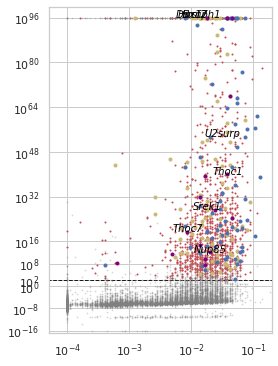

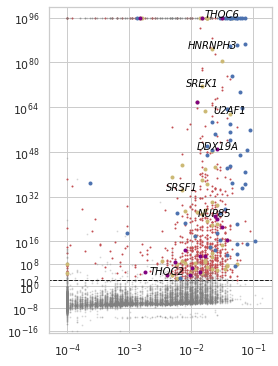

In [52]:
k_bound_lo = 1e-4 #1e-4 unit: min^-1: 1 per 7 days #same as in Bayes_factor_20220307.ipynb
N_range = 8 #same as in Bayes_factor_20220307.ipynb
x_range = [k_bound_lo*10**(i) for i in range(-1, N_range+1)]
y_range = np.asarray([1e-16, 1e-8, 1e0, 1e2, 1e8,1e16,1e32, 1e48, 1e64, 1e80, cap])
nd_cmap = ['y','b','purple']#'c','g',
visual_genes = dict()
visual_genes['m'] = {'Srsf2','U2surp','Srek1','Hnrnph1','Ddx17','Thoc1','Nup85', 'Thoc7'}
visual_genes['h'] = {'SRSF1','U2AF1','SREK1','HNRNPH3','DDX19A', 'THOC2','NUP85', 'THOC6'}


for o in organisms:
    for ot in OUT_TYPES[:1]:
    
        x =  vc[o][ts+ot]
        y =  vc[o][bf]

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(4,6))#inches

        leg = ['','']#['nuclear degradation', 'other']
        g = plt.errorbar(x[vc[o]['nucdeg']], 
                         y[vc[o]['nucdeg']],
                     fmt="o",alpha=1,markersize=1,color='r',#MS figure: markersize=1
                     elinewidth=0.5)#size=1.5)
        

        plt.errorbar(x[~vc[o]['nucdeg']], 
                     y[~vc[o]['nucdeg']],
                     fmt="o",alpha=0.2,markersize=1,color='grey',
                     elinewidth=0.5)#size=1.5)
              
        for i, go_term in enumerate(nd_plot_GO[o]):        
            plt.errorbar(x[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])], 
                         y[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])],
                         fmt="o",alpha=1,markersize=3,color=nd_cmap[i],
                         elinewidth=0.5)#size=1.5)
            leg.append('')#'nuclear degradation: %s' % go_term)

        
        plt.plot(x_range, T_bf * np.ones(len(x_range)),'--k',linewidth=1)
        

#         if o == 'h':
            #add target names to plot
        for i in vc[o][vc[o]['Symbol'].isin(visual_genes[o])].index:
            gname = vc[o]['Symbol'][i]
            x_txt = x[i]
            y_txt = y[i]#+0.01
#             ax.annotate('figure pixels',
#             xy=(10, 10), xycoords='xydata')
            ax.text(x_txt, y_txt, gname, horizontalalignment='center', color='black', size=10,
                   weight='regular', fontstyle='italic')#'semibold',

    
        ax.set_xscale('log')
        ax.set_yscale('log')
        lim_min_x = 0.5 * max(min(x),1e-4) #min(min(x), min(y))
        lim_max_x = 0.2 #max(x)#2 * max(x)#max(max(x), max(y))
        lim_min_y = 0.2 * min(min(y),eps) #min(min(x), min(y))
        lim_max_y = max(max(y), cap*(10**4))#max(max(x), max(y))
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.xlim(lim_min_x, lim_max_x)
        plt.ylim(lim_min_y, lim_max_y)

#         plt.xlabel(ts)
#         plt.ylabel(bf)

        filename = 'Nucdeg_xknucdeg'+ot+'_y'+bf+'_scat_'+o+'.'
        plt.savefig(os.path.join(path,filename+'pdf'),bbox_inches="tight",transparent=True)
#         plt.savefig(os.path.join(path,filename+'tiff'),bbox_inches="tight",transparent=True,dpi=300)
#         plt.savefig(os.path.join(path,filename+'png'),bbox_inches="tight",transparent=True,dpi=300)

### RPGs with nuc deg

In [39]:
gtemp = list(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (vc[o]['nucdeg'])]['Symbol'].sort_values())
logger.info('# of RPG nucdeg genes: %d' % len(gtemp))
logger.info(gtemp)

INFO: [2023-03-20 18:13:49] Function - # of RPG nucdeg genes: 55
INFO: [2023-03-20 18:13:49] Function - ['FAU', 'RPL10', 'RPL10A', 'RPL11', 'RPL12', 'RPL13', 'RPL13A', 'RPL14', 'RPL17', 'RPL18', 'RPL18A', 'RPL24', 'RPL27', 'RPL27A', 'RPL28', 'RPL3', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL36', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7A', 'RPLP0', 'RPLP1', 'RPS10', 'RPS11', 'RPS14', 'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27A', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS5', 'RPS8', 'RPS9', 'RPSA', 'UBA52']


In [40]:
gtemp = list(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (~vc[o]['nucdeg'])]['Symbol'].sort_values())
logger.info('# of not nucdeg RPGs: %d' % len(gtemp))
logger.info(gtemp)

# len(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (vc[o]['nucdeg'])])

INFO: [2023-03-20 18:14:13] Function - # of not nucdeg RPGs: 23
INFO: [2023-03-20 18:14:13] Function - ['DAP3', 'RPL10L', 'RPL21', 'RPL22L1', 'RPL26', 'RPL26L1', 'RPL29', 'RPL30', 'RPL35A', 'RPL36A', 'RPL36AL', 'RPL39L', 'RPL7', 'RPL7L1', 'RPL8', 'RPL9', 'RPS12', 'RPS13', 'RPS20', 'RPS21', 'RPS27', 'RPS27L', 'RPS4X']


In [41]:
gtemp = list(B[o][(B[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & 
                  (~B[o]['Gene'].isin(vc[o]['Gene']))]['Symbol'].sort_values())
logger.info('# of RPGs without Bayes factor (undecided): %d' % len(gtemp))
logger.info(gtemp)


INFO: [2023-03-20 18:14:14] Function - # of RPGs without Bayes factor (undecided): 9
INFO: [2023-03-20 18:14:14] Function - ['RPL15', 'RPL19', 'RPL22', 'RPL23', 'RPL23A', 'RPLP2', 'RPS2', 'RPS6', 'RPS7']


In [42]:
gtemp = list(B[o][(B[o]['Gene'].isin(rpg['Ensembl gene ID'])) & 
                  (~B[o]['Gene'].isin(rpg_w_times['Ensembl gene ID']))]['Symbol'].sort_values())
logger.info('# of RPGs without rates: %d' % len(gtemp))
logger.info(gtemp)

INFO: [2023-03-20 18:14:14] Function - # of RPGs without rates: 3
INFO: [2023-03-20 18:14:14] Function - ['RPL3L', 'RPS4Y1', 'RPS4Y2']


In [85]:
!pip freeze

asteval==0.9.23
attrs==19.3.0
backcall==0.1.0
backports.zoneinfo==0.2.1
bleach==3.1.4
certifi==2021.5.30
cffi==1.15.0
charset-normalizer==2.0.1
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
future==0.18.2
goatools==1.1.6
gtfparse==1.2.1
idna==3.2
importlib-metadata==1.5.2
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.16.0
Jinja2==2.11.1
joblib==1.1.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-core==4.6.3
kiwisolver==1.1.0
llvmlite==0.36.0
lmfit==1.0.2
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mpmath==1.2.1
nbconvert==5.6.1
nbformat==5.0.4
networkx==2.4
notebook==6.0.3
numba==0.53.1
numba-scipy==0.3.0
numpy==1.16.5
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.2
patsy==0.5.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.0.0
prometheus-client==0.7.1
prompt-toolkit==3.0.4
ptyprocess==0.6.0
pycparser==2.21
pydot==1.4.2
Pygments==2.6.1
pyparsing==2.4.6
pyrsistent==0.16.0

In [86]:
%%R 
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-3 ggplot2_3.3.5      pheatmap_1.0.12   

loaded via a namespace (and not attached):
 [1] fansi_1.0.3      withr_2.5.0      utf8_1.2.2       crayon_1.5.1    
 [5] grid_4.1.1       R6_2.5.1         lifecycle_1.0.1  gtable_0.3.0    
 [9] magrittr_2.0.3   scales_1.1.1     pillar_